# PSD for Each Ship Type for Multiple Locations

Uses pickle (json) files to get PSD data and aggregates it in SPDF plot by ship type for 3 locations.

Check following list for creation of SPDF with probabilities: https://github.com/Ocean-Data-Lab/Website-backend/blob/master/SpecGraph/SPDF.py

In [1]:
# data
from obspy import read as obsread
import ooipy
from ooipy.tools import ooiplotlib as ooiplt
import pandas as pd
import numpy as np
#import functions as fn
# plotting
#import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as colors
from matplotlib.colors import Normalize
from matplotlib.backends.backend_agg import FigureCanvasAgg
# IO
from io import BytesIO
import io
import json
from scipy.io import wavfile

# general
from datetime import datetime
import re

from scipy.signal import welch

## PSD and SPDF Plotting functions

### Functions

In [2]:
def get_PSD_dict(meta_data_CSV_path, location, close_distance=False):
    """
    Generate a dictionary that holds PSD data
    Ex. psd_dict[ship_type][freq_values] # not actual key names
    This data gets passed into the spdf generation and plotting functions
    
    Parameters
    ----------
    meta_data_CSV_path : str
        A file path that points to the .csv that contains the metadata. 
        Mainly used to group based on ship type (ud_group). Also matches instance_id
        to corresponding ship type.

    location : str
        String containing location of the hydrophone (i.e. Axial_Base).
        Used for file pathing

    Returns
    -------
    dict: a nested dictionary for ship type and their respective PSD data
    """

    df = pd.read_csv(meta_data_CSV_path, sep=',')

    if close_distance:
        depth_dict = {
            "Axial_Base": 3,
            "Eastern_Caldera": 1.5,
            "Central_Caldera": 1.5,
            "Oregon_Slope": 3,
            "Southern_Hydrate": 0.8
        }
        # subset to close instances
        df = df.loc[df["mean_distance(in kms)"] <= depth_dict[location]]
        df = df.reset_index(drop=True)

    # EC is the only one with missing ship type and only 4 of them, just ignore those
    # .dropna() followed by .groupby() cleans and groups
    grouped_df = df.dropna(subset=['ud_group']).groupby('ud_group')

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSDs = {}
    for group_name, df_group in grouped_df:
        PSD_obj_list = []
        PSD_freq = []
        PSD_val = []
        dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

        # for-loop to compile list of PSD data objects pulled from column
        for row_index, row in df_group.iterrows():
            inst_id = df['instance_id'].iloc[row_index]
            # get pickle files (DL locally? Call some API?)
            # local storage method
            data_path = 'data/' + location + '/'
            pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
            # try-except deals with missing pickles
            try:
                with open(pklfilepath, 'rb') as f:
                    dict1 = json.load(f)
                #print("----------PKL FOUND----------")
                # create PSD object and fill out PSD object fields
                psd = ooipy.Psd(dict1['f'], dict1['psd'])
                dictPSD['objects'].append(psd)
                dictPSD['frequencies'].append(psd.freq)
                dictPSD['values'].append(psd.values)
            except FileNotFoundError:
                #print("Could not find pkl")
                pass
        PSDs.update({group_name: dictPSD})
    return PSDs

# function pulled from https://github.com/Ocean-Data-Lab/Website-backend     
def get_spdf(spec, fs_hz=200, fmax=None, spl_bins=np.linspace(0, 120, 481),
             percentiles=[1, 5, 10, 50, 90, 95, 99]):
    if fmax is None:
        fmax = 100 #spec.frequency[-1]

    n_freq_bin = int(len(spec['frequencies'][0]) * fmax/(fs_hz/2)) + 1

    spdf_dct = {'freq': np.array(np.linspace(0, fmax, n_freq_bin)),
                'spl': spl_bins[:-1],
                'pdf': np.empty((n_freq_bin, 480))
                #'number_psd': len(spec.time) this isn't used
                }

    for p in percentiles:
        spdf_dct[str(p)] = np.empty(n_freq_bin)

    for idx, freq_bin in enumerate(np.asarray(spec['values']).T[:n_freq_bin - 1]):
        hist, _ = np.histogram(freq_bin, bins=spl_bins, density=True)
        spdf_dct['pdf'][idx] = hist
        spdf_dct['50'][idx] = np.median(freq_bin)
        for p in percentiles:
            spdf_dct[str(p)][idx] = np.nanquantile(freq_bin, p/100)

    return spdf_dct

def plot_spdf(spdf, vmin=0.003, vmax=0.2, vdelta=0.0025, save=False, filename=None, log=True, title='Spectral PDF', shipType=None, location=None):
    cbarticks = np.arange(vmin, vmax+vdelta, vdelta)
    fig, ax = plt.subplots(figsize=(9, 5))
    im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),
                     cbarticks, norm=colors.Normalize(vmin=vmin, vmax=vmax),
                     cmap='jet', extend='max', alpha=0.50, linewidth=0)

    # plot some percentiles:
    plt.plot(spdf['freq'], spdf['1'], color='black')
    plt.plot(spdf['freq'], spdf['5'], color='black')
    plt.plot(spdf['freq'], spdf['10'], color='black')
    plt.plot(spdf['freq'], spdf['50'], color='black')
    plt.plot(spdf['freq'], spdf['90'], color='black')
    plt.plot(spdf['freq'], spdf['95'], color='black')
    plt.plot(spdf['freq'], spdf['99'], color='black')

    plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{μ Pa^2}{Hz}}$)')
    plt.xlabel('frequency (Hz)')
    plt.ylim([36, 100])
    plt.xlim([0, 90])
    if log:
        plt.xscale('log')

    plt.colorbar(im, ax=ax, ticks=[vmin, vmin + (vmax-vmin)/4, vmin + (vmax-vmin)/2,
                 vmin + 3*(vmax-vmin)/4,  vmax],  pad=0.03, label='probability', format='%.3f')
    plt.tick_params(axis='y')
    plt.grid(True)
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    line = Line2D(
        [0], [0], label='percentiles: 1, 5, 10, 50, 90, 95, 99', color='k')
    handles.extend([line])
    plt.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.xlim((200/512, 100))
    filepath = 'data/'+location+'/'
    #plt.savefig(filepath+shipType+'.jpg', format='jpg')
    plt.savefig(filepath+title+'.jpg', format='jpg')
    plt.close() # suppress plotting

def get_PSD_dict_given_filt_df(df, location, close_distance=False):
    df = df.reset_index(drop=True)
    """df = pd.read_csv(meta_data_CSV_path, sep=',')

    if close_distance:
        depth_dict = {
            "Axial_Base": 3,
            "Eastern_Caldera": 1.5,
            "Central_Caldera": 1.5,
            "Oregon_Slope": 3,
            "Southern_Hydrate": 0.8
        }
        # subset to close instances
        df = df.loc[df["mean_distance(in kms)"] <= depth_dict[location]]
        df = df.reset_index(drop=True)"""

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSD_obj_list = []
    PSD_freq = []
    PSD_val = []
    dictPSD = {'objects': PSD_obj_list, 'frequencies': PSD_freq, 'values': PSD_val}

    # for-loop to compile list of PSD data objects pulled from column
    for row_index, row in df.iterrows():
        inst_id = df['instance_id'].iloc[row_index]
        # get pickle files (DL locally? Call some API?)
        # local storage method
        data_path = 'data/' + location + '/'
        pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.json'
        #if (location == 'Eastern_Caldera'):
        #    pklfilepath = data_path + 'PSD_pickles/' + inst_id + '.pkl'
        # try-except deals with missing pickles
        try:
            with open(pklfilepath, 'rb') as f:
                dict1 = json.load(f)
            #print("----------PKL FOUND----------")
            # create PSD object and fill out PSD object fields
            psd = ooipy.Psd(dict1['f'], dict1['psd'])
            dictPSD['objects'].append(psd)
            dictPSD['frequencies'].append(psd.freq)
            dictPSD['values'].append(psd.values)
        except FileNotFoundError:
            #print("Could not find pkl")
            pass
    #PSDs.update({group_name: dictPSD})
    return dictPSD

def Rx_level_from_df(df,location):

    """
    Requires dataframe for specific MMSI and maybe filtered to be sufficiently close to hydrophone.

    Return lists that contain range values (closest to farthest) within a set range (df param should already be filtered),
    and a list that contains the receive level, which is calculated from the FFT of the time series data.
    Due to needing the time series data, may be time-consuming to run.
    This data can be used to get source levels by adding/making up from Tx loss using a separate function.

    Parameters
    ----------
    df : Pandas dataframe
        A dataframe that is filtered to only contain one MMSI. Should probably also be close to hydrophone.

    Returns
    -------
    R : a list of range values in kilometers. When using it for Tx loss, need to make it an array and *1000 to get meters.

    Rx_level : a list of receive levels


    """

    df = df.sort_values(by=['mean_distance(in kms)'])
    df = df.reset_index(drop=True)

    Rx_level = []
    R = []
    file404 = 0
    for row_index, row in df.iterrows():
        try:
            inst = df['instance_id'].loc[row_index]
            #print(inst)
            st = obsread('data/'+location+'/Mseed/'+inst+'.mseed')
            data = st[-1].data
            #print(st[-1])
            
            Fs = 200
            N = len(data)
            freqs = np.linspace(-(Fs/2), Fs/2, N) # divide by 2 for nyquist, center on zero for fftshift. N points to match with N points in recording
            ft_data = np.fft.fft(data)
            idx_5hz = 63000 # index corresponding to frequency of 5 on the frequency domain centered on zero
            idx_90hz = 114000

            # Follows equation to get sound exposure
            SE = np.sum(np.fft.fftshift(np.abs(ft_data)**2)[idx_5hz:idx_90hz] / (N * Fs))
            SEL = 10 * np.log10(SE) # dB conversion
            #print(f'SEL = {SEL}')
            Rx_level.append(SEL)
            R.append(df['mean_distance(in kms)'].loc[row_index])
            #print(df['mean_distance(in kms)'].loc[row_index])
        except FileNotFoundError:
            file404 +=  1
            pass

    print(f'Files not found: {file404}')
    return R, Rx_level

Tx_loss1 = lambda x: 20*np.log10(x*1000)
#Tx_loss2 = lambda x: 20*np.log10(3*1000)+10*np.log10((x*1000)/(3*1000))

def Tx_loss2(x, location):
    depth_dict = {
            "AB": 3,
            "EC": 1.5,
            "CC": 1.5,
            "OS": 3,
            "SH": 0.8
        }
    return 20*np.log10(depth_dict[location]*1000)+10*np.log10((x*1000)/(depth_dict[location]*1000))


### Generate plots for 3 locations

In [9]:
AB_PSDs = get_PSD_dict('data/Axial_Base/AB_isolated_ais_10m_5_20.csv', location='Axial_Base')
for key in AB_PSDs:
    print((key))
    spdf = get_spdf(AB_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Axial_Base')

CC_PSDs = get_PSD_dict('data/Central_Caldera/CC_isolated_ais_10m_5_20.csv', location='Central_Caldera')
for key in CC_PSDs:
    print(key)
    spdf = get_spdf(CC_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Central_Caldera')

EC_PSDs = get_PSD_dict('data/Eastern_Caldera/EC_isolated_ais_5_20.csv', location='Eastern_Caldera')
for key in EC_PSDs:
    print(key)
    spdf = get_spdf(EC_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Eastern_Caldera')

OS_PSDs = get_PSD_dict('data/Oregon_Slope/OS_isolated_ais_5_20.csv', location='Oregon_Slope')
for key in OS_PSDs:
    print(key)
    spdf = get_spdf(OS_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Oregon_Slope')

SH_PSDs = get_PSD_dict('data/Southern_Hydrate/SH_isolated_ais_5_20.csv', location='Southern_Hydrate')
for key in SH_PSDs:
    print(key)
    spdf = get_spdf(SH_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Spectral PDF', shipType=key, location='Southern_Hydrate')

Cargo


C:\Users\UserALai\AppData\Local\Temp\ipykernel_11440\2326760358.py:101: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


Fishing type
Passenger
Recreational
Research
Tanker
Cargo
Fishing type
Offshore
Other purpose
Research
Tanker
Cargo
Fishing type
Offshore
Other purpose
Research
Tanker
Cargo
Fishing type
Other purpose
Passenger
Recreational
Tanker
drop
Cargo
Fishing type
Other purpose
Passenger
Recreational
Tanker
drop


### Generate SPDF for close data (close to hydrophone)

Assigned 4/18/23

Issues with Eastern Caldera pickles, subsetting to closer instances causes no PSD data to be read. Also happens with Fishing type ships in Southern Hydrate. After debugging w/ print statements, it seems that we just don't have the pickle files for that? Khirod has also updated the pickle file folder after I already downloaded. Before I had ~5410 files. The newer one has 6250. Using the older one, I was able to generate SPDFs for at least 2 ship types for EC. Using newer ones, I was not able to generate any. Older one has pickles for at least 2 ship types.

In [38]:
print('printing AB -------------------------------------------------------------------')
AB_PSDs = get_PSD_dict('data/Axial_Base/AB_isolated_ais_10m_5_20.csv', location='Axial_Base', close_distance=True)
for key in AB_PSDs:
    print((key))
    spdf = get_spdf(AB_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Close Distance Spectral PDF', shipType=key, location='Axial_Base')
print('printing AB -------------------------------------------------------------------')
CC_PSDs = get_PSD_dict('data/Central_Caldera/CC_isolated_ais_10m_5_20.csv', location='Central_Caldera', close_distance=True)
for key in CC_PSDs:
    print(key)
    spdf = get_spdf(CC_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Close Distance Spectral PDF', shipType=key, location='Central_Caldera')
print('printing AB -------------------------------------------------------------------')
"""EC_PSDs = get_PSD_dict('data/Eastern_Caldera/EC_isolated_ais_10m_5_20.csv', location='Eastern_Caldera', close_distance=True)
for key in EC_PSDs:
    print(key)
    spdf = get_spdf(EC_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Close Distance Spectral PDF', shipType=key, location='Eastern_Caldera')"""
print('printing AB -------------------------------------------------------------------')
OS_PSDs = get_PSD_dict('data/Oregon_Slope/OS_isolated_ais_10m_5_20.csv', location='Oregon_Slope', close_distance=True)
for key in OS_PSDs:
    print(key)
    spdf = get_spdf(OS_PSDs[key])
    plot_spdf(spdf, log=False, title=key + ' Close Distance Spectral PDF', shipType=key, location='Oregon_Slope')
print('printing AB -------------------------------------------------------------------')
SH_PSDs = get_PSD_dict('data/Southern_Hydrate/SH_isolated_ais_10m_5_20.csv', location='Southern_Hydrate', close_distance=True)
for key in SH_PSDs:
    print(key)
    try:
        spdf = get_spdf(SH_PSDs[key])
        plot_spdf(spdf, log=False, title=key + ' Close Distance Spectral PDF', shipType=key, location='Southern_Hydrate')
    except:
        pass

----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
Could not find pkl
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND--

C:\Users\UserALai\AppData\Local\Temp\ipykernel_11984\352124825.py:101: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


Fishing type
Recreational
Research
Tanker
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
Could not find pkl
Could not find pkl
Could not find pkl
----------PKL FOUND----------
----------PKL FOUND----------
----------PKL FOUND----------
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could not find pkl
Could 

In [30]:
EC_PSDs = get_PSD_dict('data/Eastern_Caldera/EC_isolated_ais_10m_5_20.csv', location='Eastern_Caldera', close_distance=True)
for key in EC_PSDs:
    print(key)
    try:
        spdf = get_spdf(EC_PSDs[key])
        plot_spdf(spdf, log=False, title=key + ' Close Distance Spectral PDF', shipType=key, location='Eastern_Caldera')
    except:
        pass

Cargo


C:\Users\UserALai\AppData\Local\Temp\ipykernel_928\2419783131.py:101: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


Fishing type
Offshore
Research
Tanker


In [31]:
EC_PSDs['Offshore']

{'objects': [], 'frequencies': [], 'values': []}

In [3]:
SH_PSDs = get_PSD_dict('data/Southern_Hydrate/SH_isolated_ais_10m_5_20.csv', location='Southern_Hydrate', close_distance=True)
for key in SH_PSDs:
    print(key)
    try:
        spdf = get_spdf(SH_PSDs[key])
        plot_spdf(spdf, log=False, title=key + 'Close Distance Spectral PDF', shipType=key, location='Southern_Hydrate')
    except:
        pass

Fishing type
Other purpose


C:\Users\UserALai\AppData\Local\Temp\ipykernel_11440\622345947.py:101: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


In [5]:
SH_PSDs['Fishing type']

{'objects': [], 'frequencies': [], 'values': []}

### Checking Broadband Spectrogram of an Axial Base and Oregon Slope instance

Refer to demo notebook from OOIPY

#### Axial Base

In [10]:
AB_df = pd.read_csv("data/Axial_Base/AB_isolated_ais_10m_5_20.csv", sep=',')
depth_dict = {
    "Axial_Base": 3,
    "Eastern_Caldera": 1.5,
    "Central_Caldera": 1.5,
    "Oregon_Slope": 3,
    "Southern_Hydrate": 0.8
}

AB_node_LF = 'Axial_Base'
AB_node_B1 = 'PC03A'
AB_node_B2 = 'LJ03A'

# subset to close instances
AB_df = AB_df.loc[AB_df["mean_distance(in kms)"] <= depth_dict[AB_node_LF]]
AB_df = AB_df.reset_index(drop=True)



AB_instance = AB_df.iloc[4]
print(AB_instance['ud_group'])
print(AB_instance['instance_id'])
start_time = datetime.strptime(AB_instance["start_time"],'%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime(AB_instance["end_time"],'%Y-%m-%d %H:%M:%S')

AB_hdata_LF = ooipy.get_acoustic_data_LF(start_time, end_time, AB_node_LF, verbose=True, zero_mean=True)
AB_hdata_B1 = ooipy.get_acoustic_data(start_time, end_time, AB_node_B1, verbose=True)
#AB_hdata_B2 = ooipy.get_acoustic_data(start_time, end_time, AB_node_B2, verbose=True)

AB_spec_B1 = AB_hdata_B1.compute_spectrogram()
#AB_spec_B2 = AB_hdata_B2.compute_spectrogram()
AB_spec_LF = AB_hdata_LF.compute_spectrogram(avg_time=1, overlap=0)

Research
AB_20160712123655_20160712124655
Fetching URLs...
Sorting valid URLs for Time Window...


c:\Users\UserALai\miniconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 4096 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


In [11]:
AB_instance['ud_group']

'Research'

c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning: The following kwargs were not used by contour: 'fmin', 'fmax', 'res_reduction_time', 'xlabel_rot', 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_format', 'ylabel', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'
  ax.contourf(


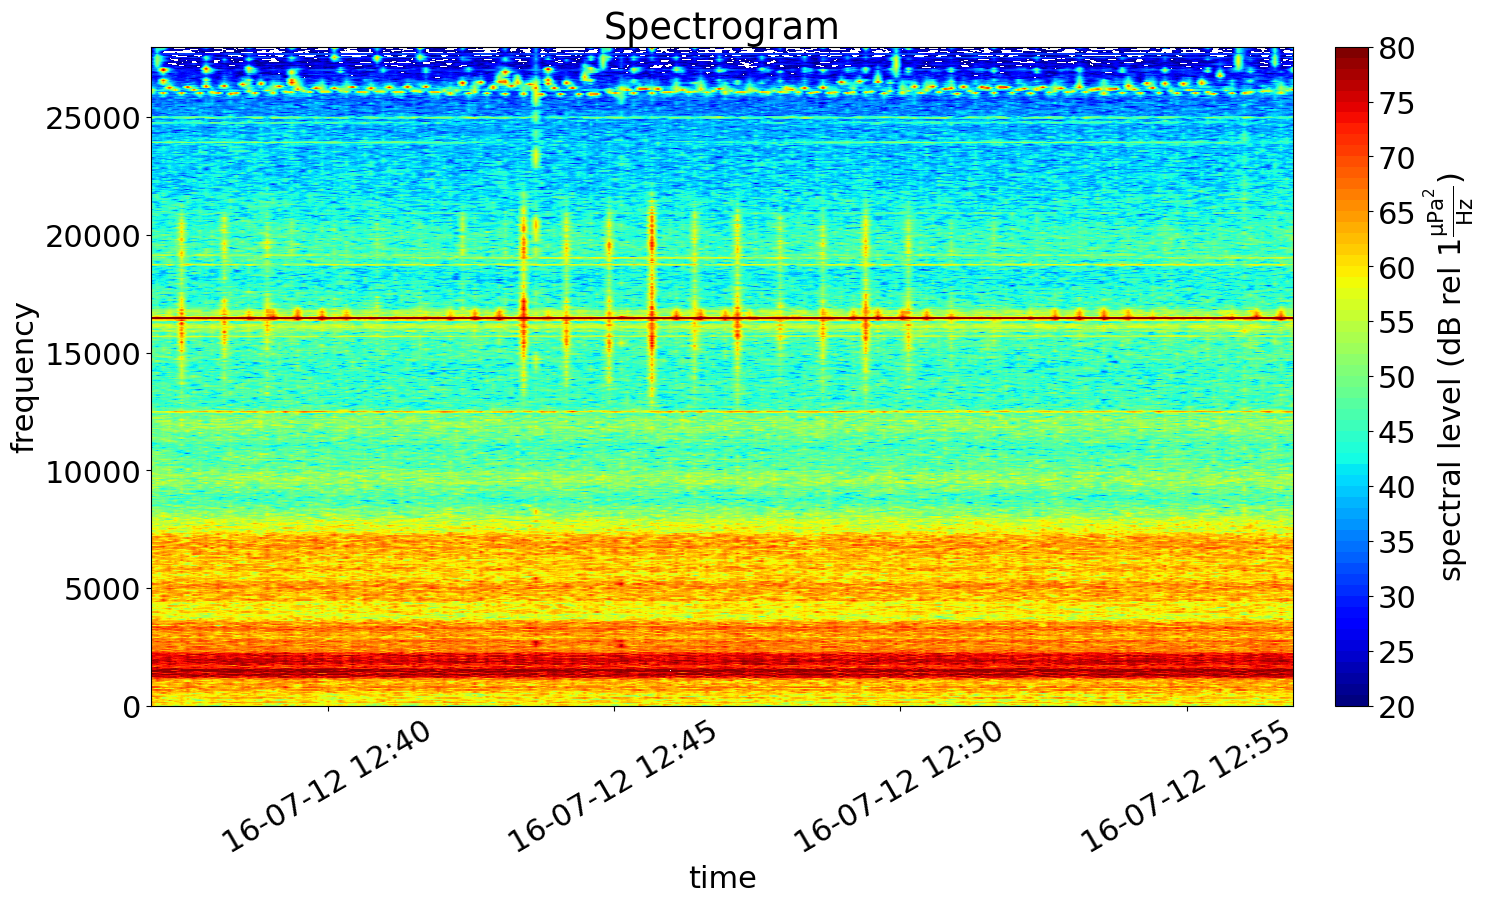

In [4]:
ooipy.plot(AB_spec_B1, fmin=0, fmax=28000, res_reduction_time=100, xlabel_rot=30)
#plt.show()

In [ ]:
ooipy.plot(AB_spec_B2, fmin=0, fmax=28000, res_reduction_time=100, xlabel_rot=30)

c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning: The following kwargs were not used by contour: 'fmin', 'fmax', 'xlabel_rot', 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_format', 'ylabel', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'
  ax.contourf(


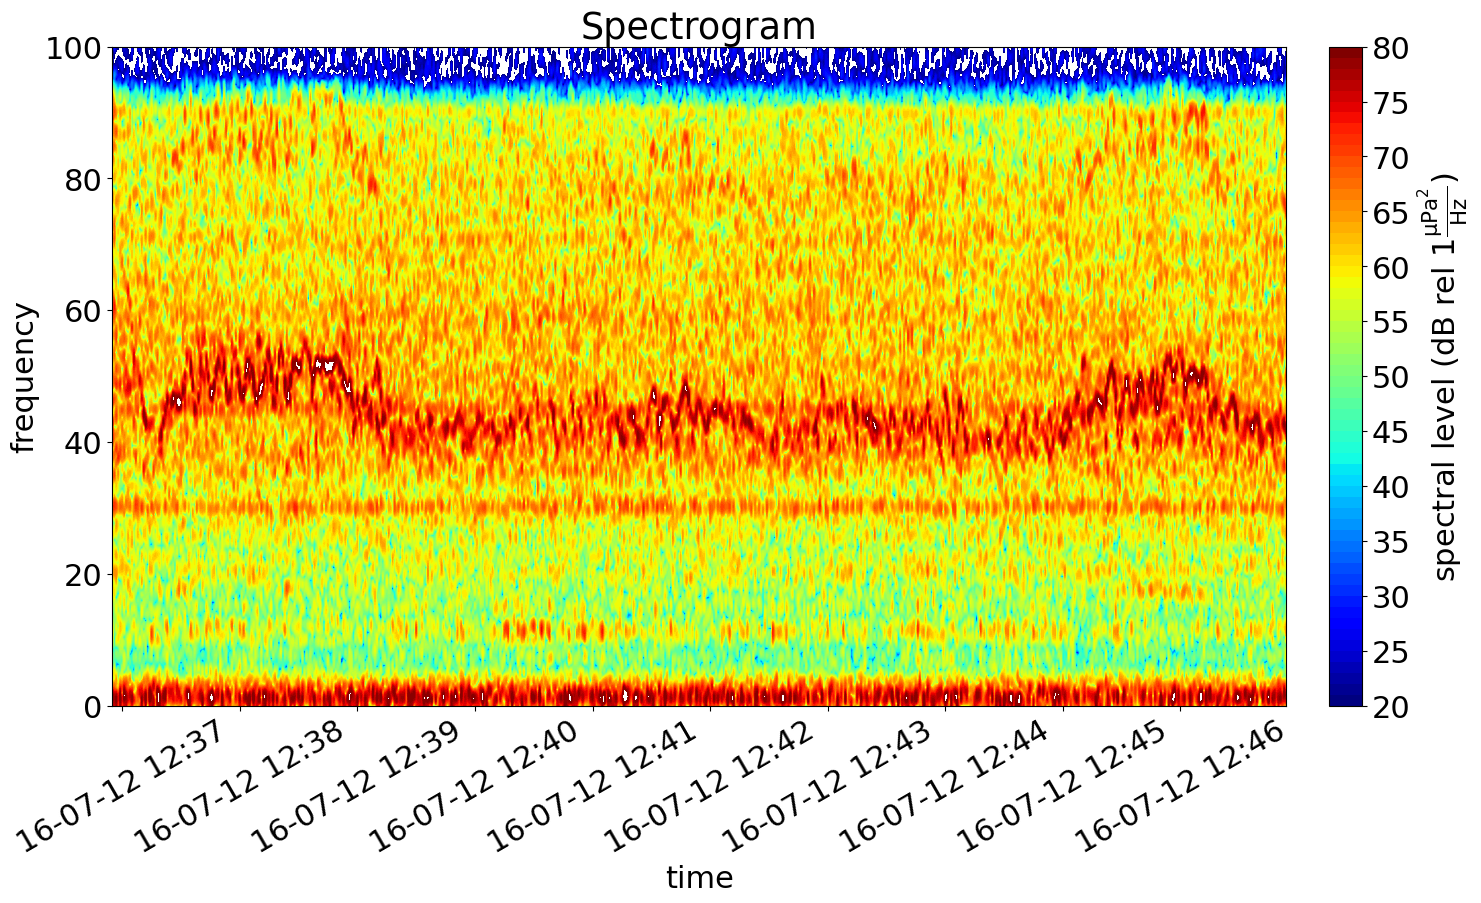

In [5]:
ooipy.plot(AB_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

#### Oregon Slope

In [45]:
OS_df = pd.read_csv("data/Oregon_Slope/OS_isolated_ais_10m_5_20.csv", sep=',')
depth_dict = {
    "Axial_Base": 3,
    "Eastern_Caldera": 1.5,
    "Central_Caldera": 1.5,
    "Oregon_Slope": 3,
    "Southern_Hydrate": 0.8
}

OS_node_LF = 'Slope_Base'
OS_node_B1 = 'LJ01A'
OS_node_B2 = 'PC01A'

# subset to close instances
OS_df = OS_df.loc[OS_df["mean_distance(in kms)"] <= depth_dict["Oregon_Slope"]]
OS_df = OS_df.reset_index(drop=True)



OS_instance = OS_df.iloc[0]
start_time = datetime.strptime(OS_instance["start_time"],'%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime(OS_instance["end_time"],'%Y-%m-%d %H:%M:%S')

OS_hdata_LF = ooipy.get_acoustic_data_LF(start_time, end_time, OS_node_LF, verbose=True, zero_mean=True)
OS_hdata_B1 = ooipy.get_acoustic_data(start_time, end_time, OS_node_B1, verbose=True)
#OS_hdata_B2 = ooipy.get_acoustic_data(start_time, end_time, OS_node_B2, verbose=True)

OS_spec_B1 = OS_hdata_B1.compute_spectrogram()
#OS_spec_B2 = OS_hdata_B2.compute_spectrogram()
OS_spec_LF = OS_hdata_LF.compute_spectrogram(avg_time=1, overlap=0)

Fetching URLs...
Sorting valid URLs for Time Window...


c:\Users\UserALai\miniconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 4096 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


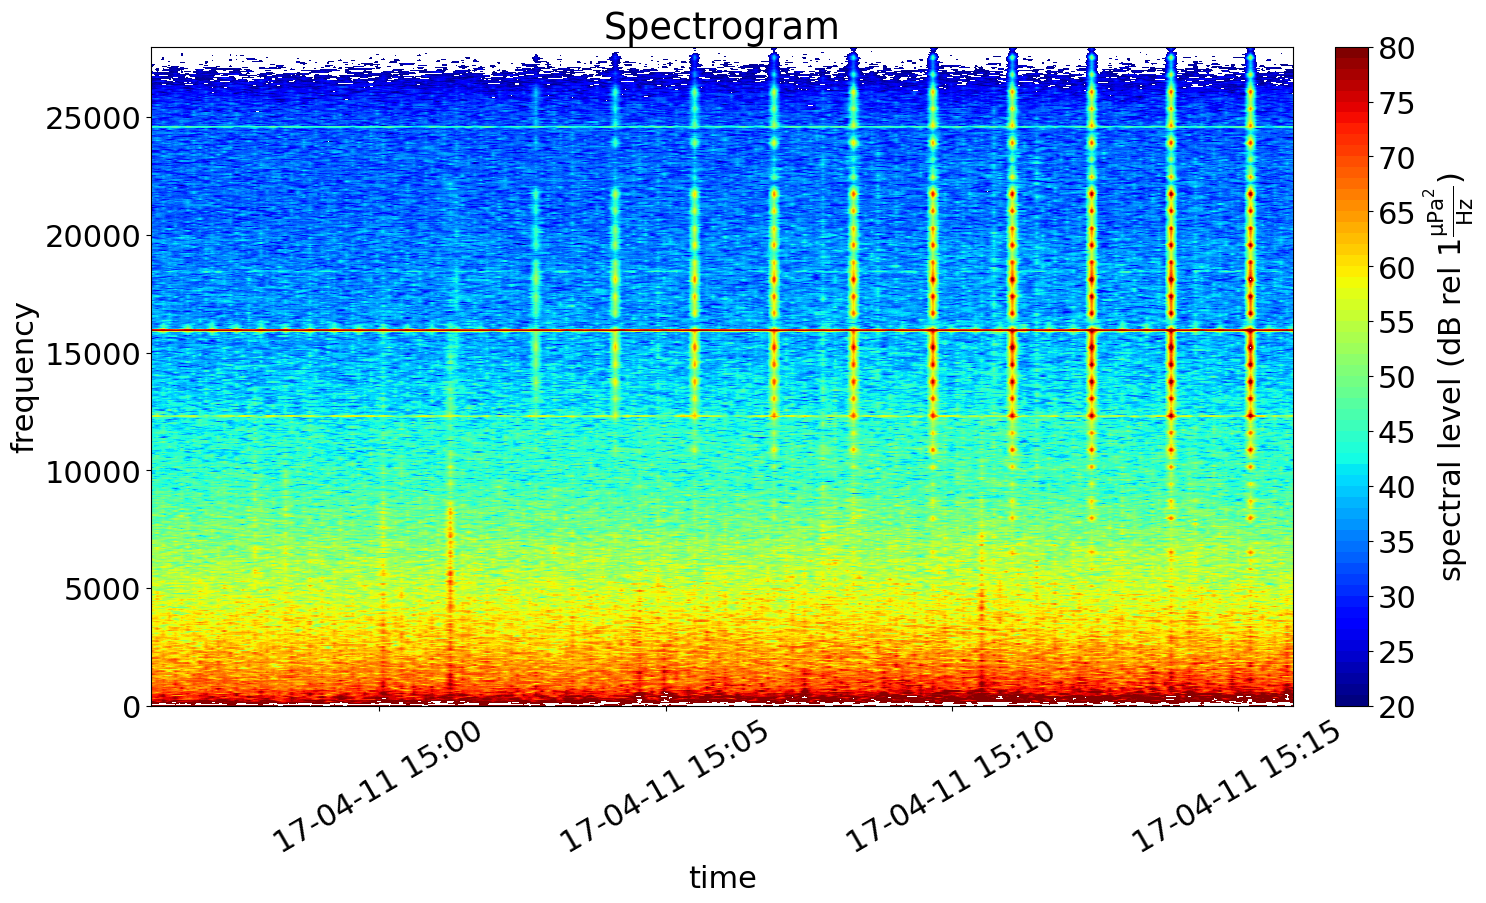

In [15]:
ooipy.plot(OS_spec_B1, fmin=0, fmax=28000, res_reduction_time=100, xlabel_rot=30)

In [ ]:
ooipy.plot(OS_spec_B2, fmin=0, fmax=28000, res_reduction_time=100, xlabel_rot=30)

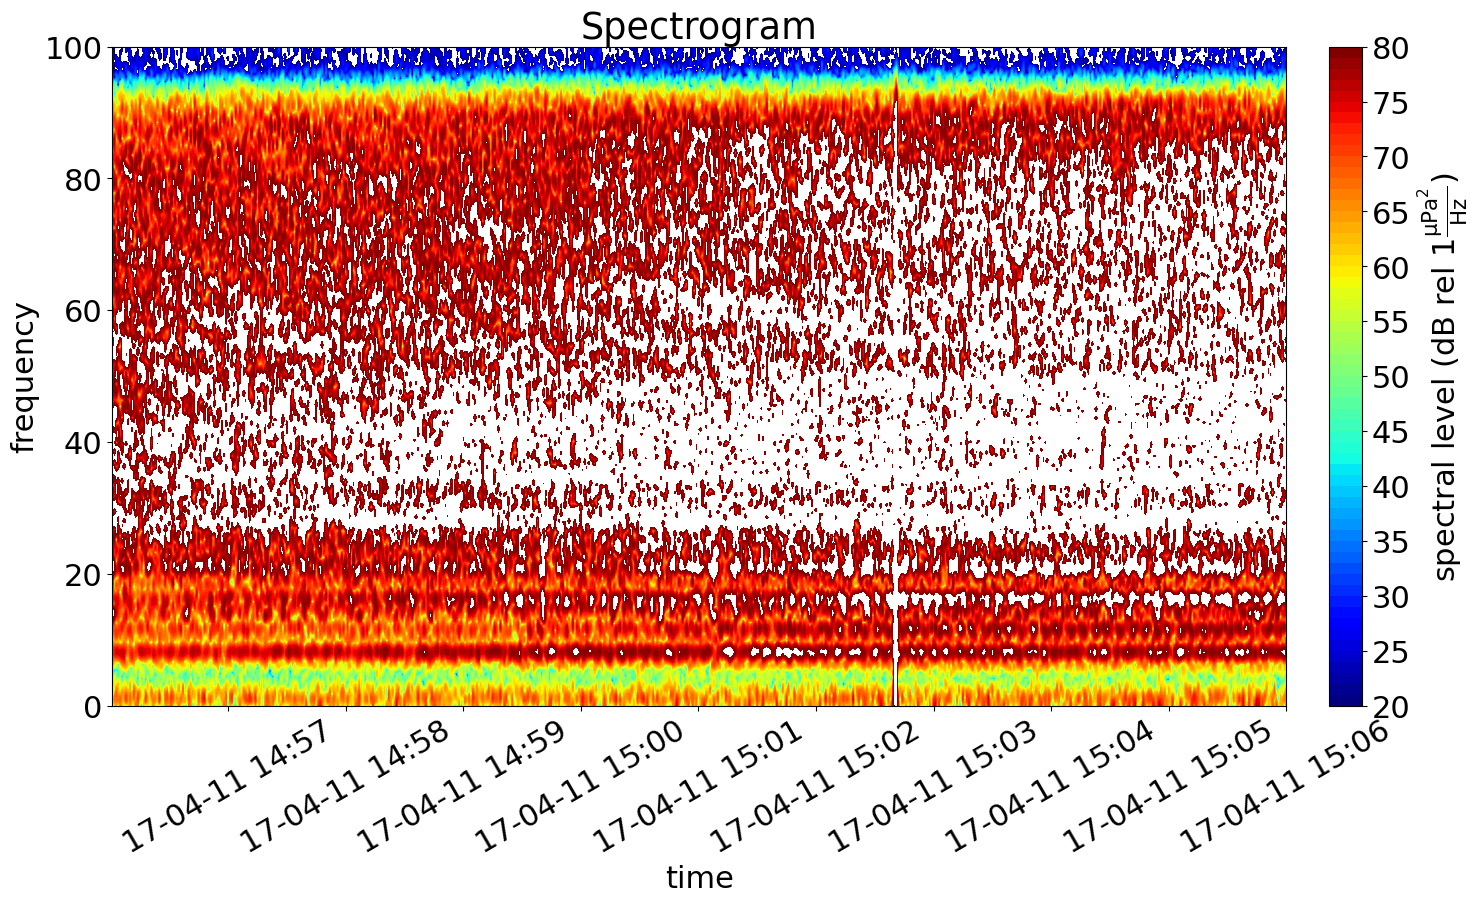

In [16]:
ooipy.plot(OS_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

### SPDF of ONE ship instance
Assigned 4/25

Will use an instance with lots (in relation to it's category) of data. Need to do this for a cargo vessel and a research vessel.

Need to find more info on the ships themselves (look up their MMSI)

#### Axial Base

In [20]:
AB_df = pd.read_csv('data/Axial_Base/AB_isolated_ais_10m_5_20.csv', sep=',')
# Most frequent Cargo ship MMSI 356190000
#   With 17 instances
# Most frequent Research ship MMSI 366345000
#   With 907 instances
#"""
key = 'Cargo'
df = AB_df[(AB_df['ud_group']==key)]# & (AB_df['mean_distance(in kms)'] < 10)]
df = df[df['MMSI']==356190000]
#df = df[(df["mean_speed(KNOTSx10)"] > 10)]
# df.groupby('MMSI').count() # this lets us see MMSI occurances
psd = get_PSD_dict_given_filt_df(df, 'Axial_Base')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF (356190000)', shipType=key, location='Axial_Base')#"""

# Research Ships
"""
key = 'Research'
df = AB_df[(AB_df['ud_group']==key)]
df = df[df['MMSI']==366345000]
# df.groupby('MMSI').count()
psd = get_PSD_dict_given_filt_df(df, 'Axial_Base')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF (366345000)', shipType=key, location='Axial_Base')#"""

# Fishing type Ships
"""key = 'Fishing type'
df = AB_df[(AB_df['ud_group']==key) & (AB_df['mean_distance(in kms)'] < 3)]
df = df[df['MMSI']==303681000]
# df.groupby('MMSI').count()
psd = get_PSD_dict_given_filt_df(df, 'Axial_Base')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF (303681000)', shipType=key, location='Axial_Base')"""

C:\Users\UserALai\AppData\Local\Temp\ipykernel_18976\438229207.py:101: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


"key = 'Fishing type'\ndf = AB_df[(AB_df['ud_group']==key) & (AB_df['mean_distance(in kms)'] < 3)]\ndf = df[df['MMSI']==303681000]\n# df.groupby('MMSI').count()\npsd = get_PSD_dict_given_filt_df(df, 'Axial_Base')\nspdf = get_spdf(psd)\nplot_spdf(spdf, log=False, title=key + ' Spectral PDF (303681000)', shipType=key, location='Axial_Base')"

In [10]:
type(df['start_time'].iloc[0])

str

##### Spectrograms of long time frame

In [21]:
feature = 'start_time'
df = df.sort_values(by=[feature])
df = df.reset_index(drop=True)
# convert format
df['start_time'] = (pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S'))
df['end_time'] = (pd.to_datetime(df['end_time'], format='%Y-%m-%d %H:%M:%S'))

# filter select
#df = df[df[feature].dt.month ==7]
df

Unnamed: 0       MMSI          start_time            end_time  \
0          458  356190000 2017-08-17 03:22:52 2017-08-17 03:32:52   
1          459  356190000 2017-08-17 03:32:52 2017-08-17 03:42:52   
2          460  356190000 2017-08-17 03:42:52 2017-08-17 03:52:52   
3          461  356190000 2017-08-17 03:52:52 2017-08-17 04:02:52   
4          462  356190000 2017-08-17 04:02:52 2017-08-17 04:12:52   
5          463  356190000 2017-08-17 04:12:52 2017-08-17 04:22:52   
6          464  356190000 2017-08-17 04:22:52 2017-08-17 04:32:52   
7          465  356190000 2017-08-17 04:32:52 2017-08-17 04:42:52   
8          466  356190000 2017-08-17 04:42:52 2017-08-17 04:52:52   
9          467  356190000 2017-08-17 04:52:52 2017-08-17 05:02:52   
10         468  356190000 2017-08-17 05:02:52 2017-08-17 05:12:52   
11         469  356190000 2017-08-17 05:12:52 2017-08-17 05:22:52   
12         470  356190000 2017-08-17 05:22:52 2017-08-17 05:32:52   
13         471  356190000 2017-08-17 05:32:52 2017-08-17 05:42:52   
14         472  356190000 2017-08-17 05:42:52 2017-08-17 05:52:52   
15         473  356190000 2017-08-17 05:52:52 2017-08-17 06:02:52   
16         474  356190000 2017-08-17 06:02:52 2017-08-17 06:12:52   

     VESSEL TYPE ud_group  len_of_recording                       instance_id  \
0   Bulk Carrier    Cargo              10.0  AB_20170817032252_20170817033252   
1   Bulk Carrier    Cargo              10.0  AB_20170817033252_20170817034252   
2   Bulk Carrier    Cargo              10.0  AB_20170817034252_20170817035252   
3   Bulk Carrier    Cargo              10.0  AB_20170817035252_20170817040252   
4   Bulk Carrier    Cargo              10.0  AB_20170817040252_20170817041252   
5   Bulk Carrier    Cargo              10.0  AB_20170817041252_20170817042252   
6   Bulk Carrier    Cargo              10.0  AB_20170817042252_20170817043252   
7   Bulk Carrier    Cargo              10.0  AB_20170817043252_20170817044252   
8   Bulk Carrier    Cargo              10.0  AB_20170817044252_20170817045252   
9   Bulk Carrier    Cargo              10.0  AB_20170817045252_20170817050252   
10  Bulk Carrier    Cargo              10.0  AB_20170817050252_20170817051252   
11  Bulk Carrier    Cargo              10.0  AB_20170817051252_20170817052252   
12  Bulk Carrier    Cargo              10.0  AB_20170817052252_20170817053252   
13  Bulk Carrier    Cargo              10.0  AB_20170817053252_20170817054252   
14  Bulk Carrier    Cargo              10.0  AB_20170817054252_20170817055252   
15  Bulk Carrier    Cargo              10.0  AB_20170817055252_20170817060252   
16  Bulk Carrier    Cargo              10.0  AB_20170817060252_20170817061252   

    min_speed(KNOTSx10)  max_speed(KNOTSx10)  ...  mean_course  min_heading  \
0                     6                    6  ...        141.0          225   
1                     5                    5  ...        330.0          315   
2                     9                    9  ...        159.0          226   
3                     5                    5  ...        162.0          346   
4                     6                    6  ...        257.0          343   
5                     3                    3  ...        284.0          316   
6                     4                    4  ...        103.0          315   
7                     4                    4  ...        316.0          329   
8                     5                    5  ...        228.0          316   
9                     1                    1  ...          5.0          317   
10                   10                   10  ...         31.0          340   
11                    1                    1  ...        212.0          343   
12                   12                   12  ...        156.0          222   
13                   10                   10  ...        157.0          223   
14                    5                    5  ...        221.0          344   
15                    5               

In [23]:
start_time = df['start_time'].iloc[0]
end_time = df['end_time'].iloc[-1]
AB_node_LF = 'Axial_Base'

AB_hdata_LF = ooipy.get_acoustic_data_LF(start_time, end_time, AB_node_LF, verbose=True, zero_mean=True)
AB_spec_LF = AB_hdata_LF.compute_spectrogram(avg_time=1, overlap=0)

ooipy.plot(AB_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

AttributeError: 'str' object has no attribute 'strftime'

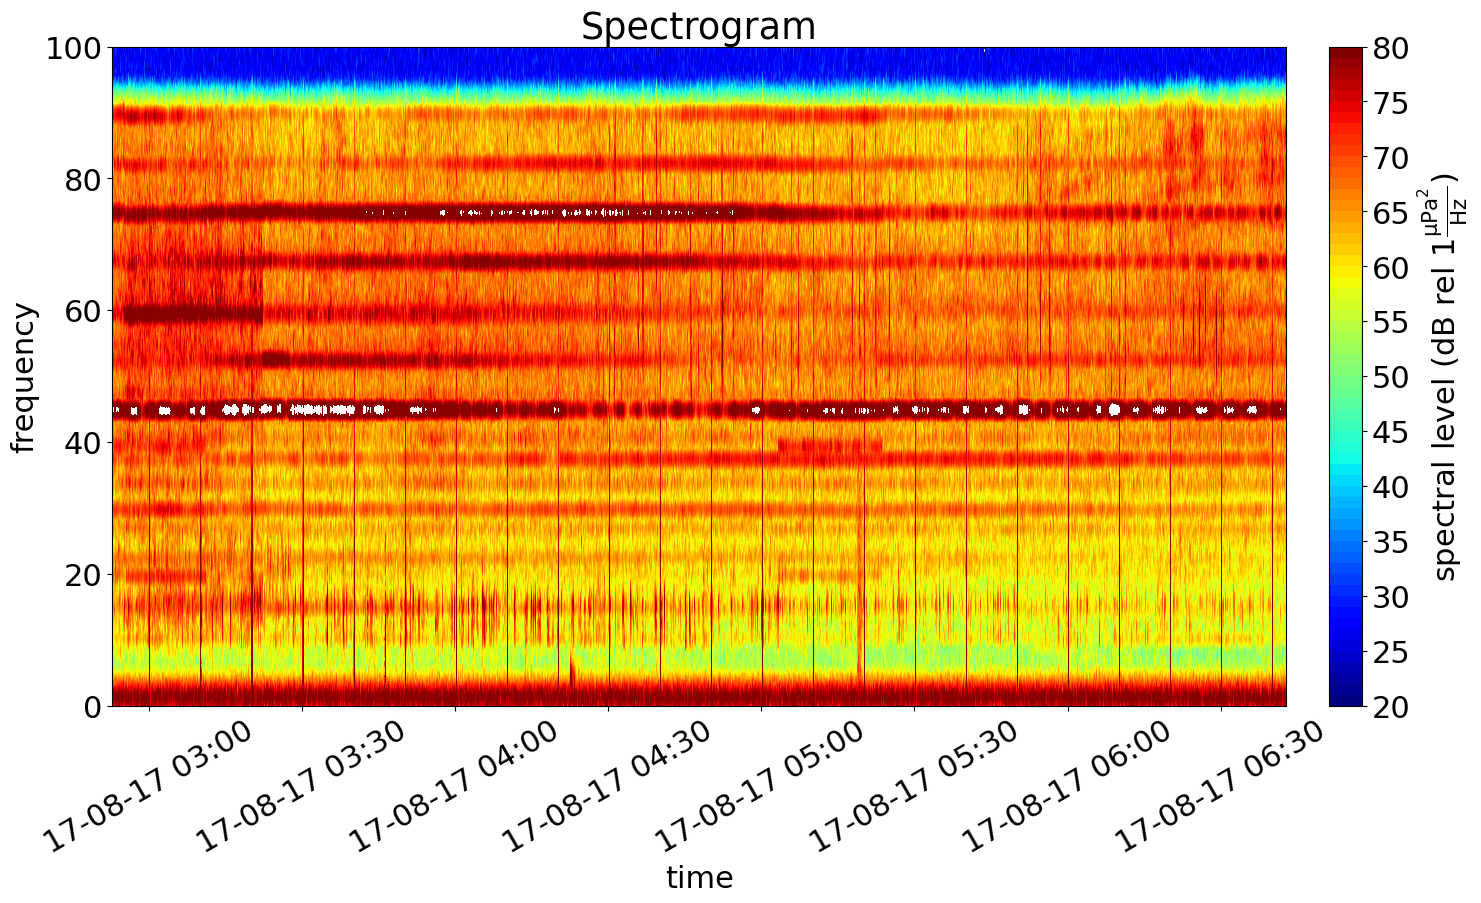

In [18]:
start_time = pd.to_datetime('2017-08-17 02:52:52', format='%Y-%m-%d %H:%M:%S')
end_time = pd.to_datetime('2017-08-17 06:42:52', format='%Y-%m-%d %H:%M:%S')
AB_hdata_LF = ooipy.get_acoustic_data_LF(start_time, end_time, AB_node_LF, verbose=True, zero_mean=True)
AB_spec_LF = AB_hdata_LF.compute_spectrogram(avg_time=1, overlap=0)

ooipy.plot(AB_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

In [14]:
print(start_time)
print(end_time)
AB_hdata_LF

2017-08-17 03:22:52
2017-08-17 06:12:52


OO.AXBA1.AXBA1.HDH | 2017-08-17T03:22:52.000000Z - 2017-08-17T06:12:52.000000Z | 200.0 Hz, 2040001 samples

##### Transmission Loss Plot

Refer to Figure 3 of McKenna et al. paper 'Underwater radiated noise from modern commercial ships'.

Text(0, 0.5, 'Mean speed (knots x 10)')

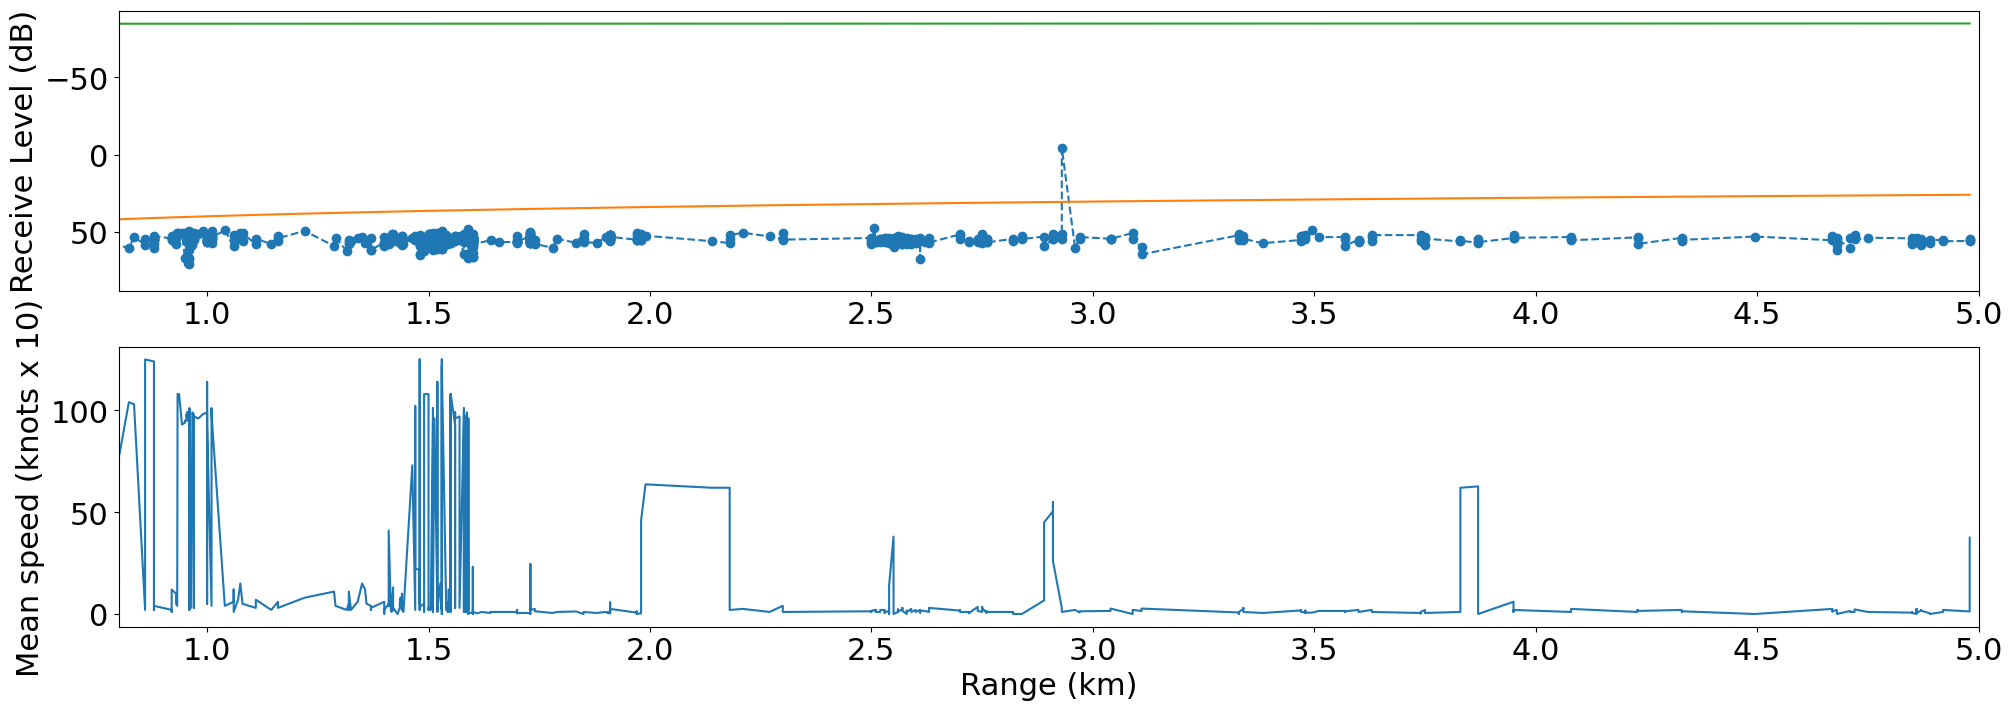

In [37]:
#R, Rx_level = Rx_level_from_df(df, 'Axial_Base')


fig, ax = plt.subplots(2, 1, figsize=(24,8))

ax[0].plot(R, Rx_level, 'o--')
ax[0].plot(R, -1*Tx_loss1(np.asarray(R))+100, label='20*log(range)')
ax[0].plot(R, -1*Tx_loss2(np.asarray(R)+100, 'AB'), label='20*np.log10(wd)+10*np.log10(range/wd)')
#ax[0].set_xlabel('Range (km)')
ax[0].set_ylabel("Receive Level (dB)")
#ax[0].legend()
#plt.ylim(47,70)
ax[0].invert_yaxis()#.gca().invert_yaxis()
ax[0].set_xlim(.8,5)
#ax[0].set_ylim(40,80)

#ax[1,0]
#ax[1].figure(figsize=(20,6))
ax[1].plot(df['mean_distance(in kms)'].sort_values(ascending=True), df["mean_speed(KNOTSx10)"])
ax[1].set_xlim(.8,5)
ax[1].set_xlabel('Range (km)')
ax[1].set_ylabel("Mean speed (knots x 10)")

##### Source Level Distribution

This is for a single instance case. May want to think about expanding to other ships and turning this code into a function.

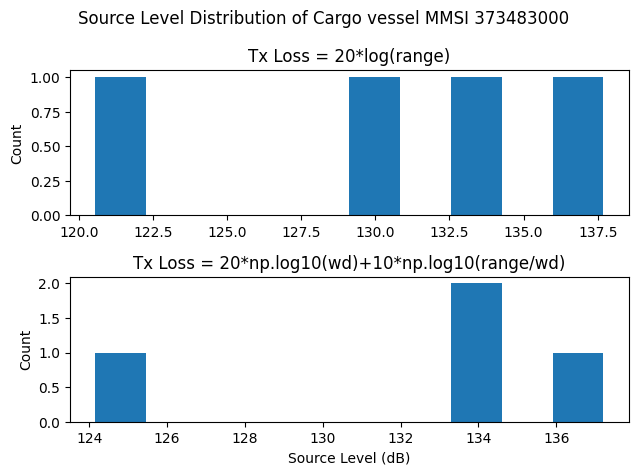

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Source Level Distribution of '+key+' vessel MMSI 373483000')
loss = np.abs(Tx_loss1(np.asarray(R)))
ax1.hist(np.ma.masked_invalid(Rx_level+loss)) # hide inf (0 divide error) since it messes w/ plotting
ax1.set_ylabel('Count')
ax1.title.set_text('Tx Loss = 20*log(range)')
loss = np.abs(Tx_loss2(np.asarray(R), 'AB'))
ax2.hist(np.ma.masked_invalid(Rx_level+loss))
ax2.set_xlabel('Source Level (dB)')
ax2.set_ylabel('Count')
ax2.title.set_text('Tx Loss = 20*np.log10(wd)+10*np.log10(range/wd)')
fig.tight_layout() 

#### Oregon Slope

In [88]:
OS_df = pd.read_csv('data/Oregon_Slope/OS_isolated_ais_10m_5_20.csv', sep=',')
# Most frequent Cargo ship MMSI 366364000
#   With 13 instances
# Most frequent Fishing type ship MMSI 303668000
#   With 10 instances
key = 'Cargo'
df = OS_df[(OS_df['ud_group']==key)]
df = df[df['MMSI']==366364000]
# df.groupby('MMSI').count() # this lets us see MMSI occurances
psd = get_PSD_dict_given_filt_df(df, 'Oregon_Slope')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF (single instance)', shipType=key, location='Oregon_Slope')

# Fishing Ships
key = 'Fishing type'
df = OS_df[(OS_df['ud_group']==key)]
df = df[df['MMSI']==303668000]
# df.groupby('MMSI').count()
psd = get_PSD_dict_given_filt_df(df, 'Oregon_Slope')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF (single instance)', shipType=key, location='Oregon_Slope')

C:\Users\UserALai\AppData\Local\Temp\ipykernel_928\2419783131.py:101: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


#### Eastern Caldera

In [7]:
EC_df = pd.read_csv('data/Eastern_Caldera/EC_isolated_ais_10m_5_20.csv', sep=',')

# Cargo
key = 'Cargo'
MMSI_1 = 356190000
df = EC_df[(EC_df['ud_group']==key)]
df = df[df['MMSI']==MMSI_1]
# df.groupby('MMSI').count() # this lets us see MMSI occurances
psd = get_PSD_dict_given_filt_df(df, 'Eastern_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI_1)+')', shipType=key, location='Eastern_Caldera')

# Offshore
"""key = 'Offshore'
MMSI_2 = 338415000
df = EC_df[(EC_df['ud_group']==key)]
df = df[df['MMSI']==MMSI_2]
# df.groupby('MMSI').count()
psd = get_PSD_dict_given_filt_df(df, 'Eastern_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI_2)+')', shipType=key, location='Eastern_Caldera')"""

# Research
"""key = 'Research'
MMSI_3 = 369565000
df = EC_df[(EC_df['ud_group']==key)]
df = df[df['MMSI']==MMSI_3]
# df.groupby('MMSI').count()
psd = get_PSD_dict_given_filt_df(df, 'Eastern_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI_3)+')', shipType=key, location='Eastern_Caldera')"""

C:\Users\UserALai\AppData\Local\Temp\ipykernel_11032\438229207.py:101: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


"key = 'Research'\nMMSI_3 = 369565000\ndf = EC_df[(EC_df['ud_group']==key)]\ndf = df[df['MMSI']==MMSI_3]\n# df.groupby('MMSI').count()\npsd = get_PSD_dict_given_filt_df(df, 'Eastern_Caldera')\nspdf = get_spdf(psd)\nplot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI_3)+')', shipType=key, location='Eastern_Caldera')"

##### Spectrogram

In [8]:
feature = 'start_time'
df = df.sort_values(by=[feature])
df = df.reset_index(drop=True)
# convert format
df['start_time'] = (pd.to_datetime(df['start_time'], format='%Y-%m-%d %H:%M:%S'))
df['end_time'] = (pd.to_datetime(df['end_time'], format='%Y-%m-%d %H:%M:%S'))

# filter select
#df = df[df[feature].dt.month ==7]
df

Unnamed: 0       MMSI          start_time            end_time  \
0          682  356190000 2017-07-27 07:13:10 2017-07-27 07:23:10   
1          683  356190000 2017-07-27 07:23:10 2017-07-27 07:33:10   
2          684  356190000 2017-07-27 07:33:10 2017-07-27 07:43:10   
3          685  356190000 2017-07-27 07:43:10 2017-07-27 07:53:10   
4          686  356190000 2017-07-27 07:53:10 2017-07-27 08:03:10   
5          687  356190000 2017-07-27 08:03:10 2017-07-27 08:13:10   
6          688  356190000 2017-07-27 08:13:10 2017-07-27 08:23:10   
7          689  356190000 2017-07-27 08:23:10 2017-07-27 08:33:10   
8          690  356190000 2017-07-27 08:33:10 2017-07-27 08:43:10   
9          691  356190000 2017-07-27 08:43:10 2017-07-27 08:53:10   
10         692  356190000 2017-07-27 08:53:10 2017-07-27 09:03:10   
11         693  356190000 2017-07-27 09:03:10 2017-07-27 09:13:10   
12         694  356190000 2017-07-27 09:13:10 2017-07-27 09:23:10   
13         695  356190000 2017-07-27 09:23:10 2017-07-27 09:33:10   
14         696  356190000 2017-07-27 09:33:10 2017-07-27 09:43:10   
15         697  356190000 2017-07-27 09:43:10 2017-07-27 09:53:10   
16         698  356190000 2017-07-27 09:53:10 2017-07-27 10:03:10   
17         699  356190000 2017-07-27 10:03:10 2017-07-27 10:13:10   
18         700  356190000 2017-07-27 10:13:10 2017-07-27 10:23:10   
19         701  356190000 2017-07-27 10:23:10 2017-07-27 10:33:10   
20         702  356190000 2017-08-16 11:49:50 2017-08-16 11:59:50   
21         703  356190000 2017-08-16 11:59:50 2017-08-16 12:09:50   
22         704  356190000 2017-08-16 12:09:50 2017-08-16 12:19:50   
23         705  356190000 2017-08-16 12:19:50 2017-08-16 12:29:50   
24         706  356190000 2017-08-16 12:29:50 2017-08-16 12:39:50   
25         707  356190000 2017-08-16 12:39:50 2017-08-16 12:49:50   
26         708  356190000 2017-08-16 12:49:50 2017-08-16 12:59:50   
27         709  356190000 2017-08-16 12:59:50 2017-08-16 13:09:50   
28         710  356190000 2017-08-16 13:09:50 2017-08-16 13:19:50   
29         711  356190000 2017-08-16 13:19:50 2017-08-16 13:29:50   
30         712  356190000 2017-08-16 13:29:50 2017-08-16 13:39:50   
31         713  356190000 2017-08-16 13:39:50 2017-08-16 13:49:50   
32         714  356190000 2017-08-16 13:49:50 2017-08-16 13:59:50   

     VESSEL TYPE ud_group  len_of_recording                       instance_id  \
0   Bulk Carrier    Cargo              10.0  EC_20170727071310_20170727072310   
1   Bulk Carrier    Cargo              10.0  EC_20170727072310_20170727073310   
2   Bulk Carrier    Cargo              10.0  EC_20170727073310_20170727074310   
3   Bulk Carrier    Cargo              10.0  EC_20170727074310_20170727075310   
4   Bulk Carrier    Cargo              10.0  EC_20170727075310_20170727080310   
5   Bulk Carrier    Cargo              10.0  EC_20170727080310_20170727081310   
6   Bulk Carrier    Cargo              10.0  EC_20170727081310_20170727082310   
7   Bulk Carrier    Cargo              10.0  EC_20170727082310_20170727083310   
8   Bulk Carrier    Cargo              10.0  EC_20170727083310_20170727084310   
9   Bulk Carrier    Cargo              10.0  EC_20170727084310_20170727085310   
10  Bulk Carrier    Cargo              10.0  EC_20170727085310_20170727090310   
11  Bulk Carrier    Cargo              10.0  EC_20170727090310_20170727091310   
12  Bulk Carrier    Cargo              10.0  EC_20170727091310_20170727092310   
13  Bulk Carrier    Cargo              10.0  EC_20170727092310_20170727093310   
14  Bulk Carrier    Cargo              10.0  EC_20170727093310_20170727094310   
15  Bulk Carrier    Cargo              10.0  EC_20170727094310_20170727095310   
16  Bulk Carrier    Cargo              10.0  EC_20170727095310_20170727100310   
17  Bulk Carrier    Cargo              10.0  EC_20170727100310_20170727101310   
18  Bulk Carrier    Cargo              10.0  EC_20170727101310_20170727102310   
19  Bulk Carrier    Cargo            

In [10]:
start_time = df['start_time'].iloc[0]
end_time = df['end_time'].iloc[-1]
EC_node_LF = 'Eastern_Caldera'

EC_hdata_LF = ooipy.get_acoustic_data_LF(start_time, end_time, EC_node_LF, verbose=True, zero_mean=True)
EC_spec_LF = EC_hdata_LF.compute_spectrogram(avg_time=1, overlap=0)

ooipy.plot(EC_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

In [12]:
start_time = pd.to_datetime('2017-07-27 06:43:10', format='%Y-%m-%d %H:%M:%S')
end_time = pd.to_datetime('2017-08-17 07:12:52', format='%Y-%m-%d %H:%M:%S')
EC_hdata_LF = ooipy.get_acoustic_data_LF(start_time, end_time, EC_node_LF, verbose=True, zero_mean=True)
EC_spec_LF = EC_hdata_LF.compute_spectrogram(avg_time=1, overlap=0)

ooipy.plot(EC_spec_LF, fmin=0, fmax=100, xlabel_rot=30)

c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning: The following kwargs were not used by contour: 'fmin', 'fmax', 'xlabel_rot', 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_format', 'ylabel', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'
  ax.contourf(


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001E66D8C7D30> (for post_execute):


KeyboardInterrupt: 

Files not found: 0


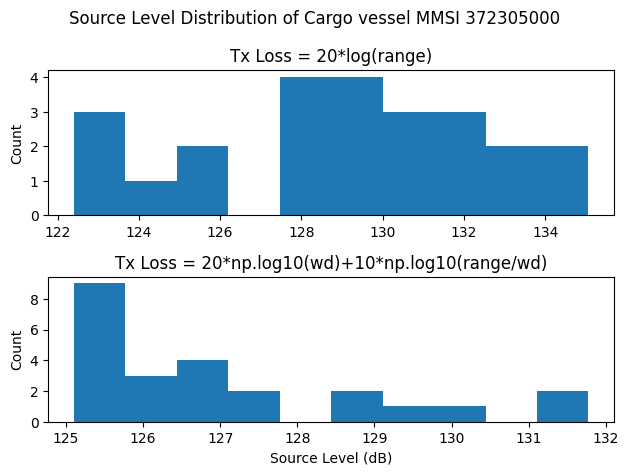

In [65]:
R, Rx_level = Rx_level_from_df(df, 'Eastern_Caldera')
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Source Level Distribution of '+key+' vessel MMSI 372305000')
loss = np.abs(Tx_loss1(np.asarray(R)))
ax1.hist(np.ma.masked_invalid(Rx_level+loss)) # hide inf (0 divide error) since it messes w/ plotting
ax1.set_ylabel('Count')
ax1.title.set_text('Tx Loss = 20*log(range)')
loss = np.abs(Tx_loss2(np.asarray(R), 'EC'))
ax2.hist(np.ma.masked_invalid(Rx_level+loss))
ax2.set_xlabel('Source Level (dB)')
ax2.set_ylabel('Count')
ax2.title.set_text('Tx Loss = 20*np.log10(wd)+10*np.log10(range/wd)')
fig.tight_layout() 

Text(0, 0.5, 'Mean speed (knots x 10)')

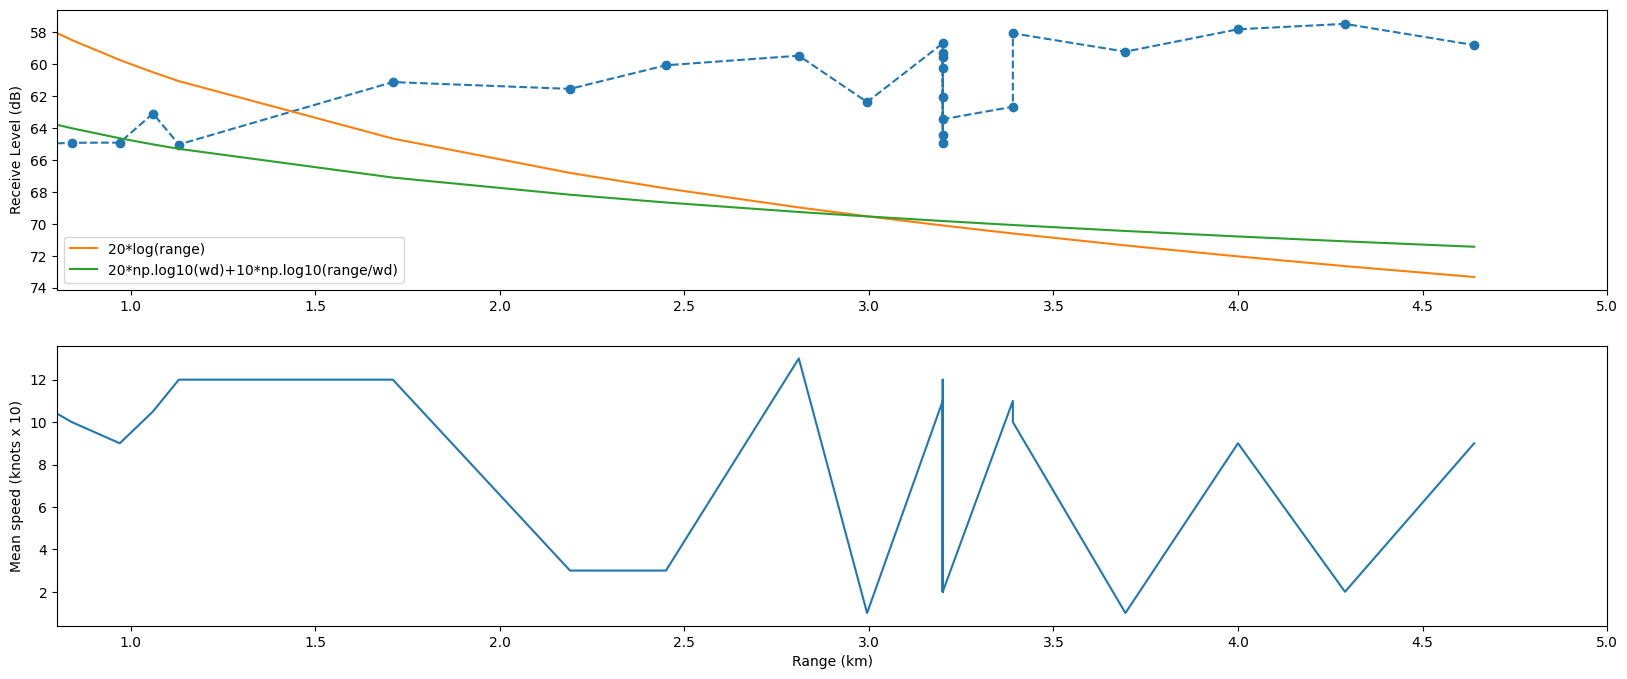

In [66]:
fig, ax = plt.subplots(2, 1, figsize=(20,8))

ax[0].plot(R, Rx_level, 'o--')
ax[0].plot(R, Tx_loss1(np.asarray(R)), label='20*log(range)')
ax[0].plot(R, Tx_loss2(np.asarray(R), 'AB'), label='20*np.log10(wd)+10*np.log10(range/wd)')
#ax[0].set_xlabel('Range (km)')
ax[0].set_ylabel("Receive Level (dB)")
ax[0].legend()
#plt.ylim(47,70)
ax[0].invert_yaxis()#.gca().invert_yaxis()
ax[0].set_xlim(.8,5)

#ax[1,0]
#ax[1].figure(figsize=(20,6))
ax[1].plot(df['mean_distance(in kms)'].sort_values(ascending=True), df["mean_speed(KNOTSx10)"])
ax[1].set_xlim(.8,5)
ax[1].set_xlabel('Range (km)')
ax[1].set_ylabel("Mean speed (knots x 10)")

#### Central Caldera

In [102]:
CC_df = pd.read_csv('data/Central_Caldera/CC_isolated_ais_10m_5_20.csv', sep=',')

# Cargo
key = 'Cargo'
MMSI_1 = 538004507
df = CC_df[(CC_df['ud_group']==key)]
df = df[df['MMSI']==MMSI_1]
# df.groupby('MMSI').count() # this lets us see MMSI occurances
psd = get_PSD_dict_given_filt_df(df, 'Central_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI_1)+')', shipType=key, location='Central_Caldera')

# Offshore
"""key = 'Offshore'
MMSI_2 = 371186000
df = CC_df[(CC_df['ud_group']==key)]
df = df[df['MMSI']==MMSI_2]
# df.groupby('MMSI').count()
psd = get_PSD_dict_given_filt_df(df, 'Central_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI_2)+')', shipType=key, location='Central_Caldera')"""

# Research
"""key = 'Research'
MMSI_3 = 367800100
df = CC_df[(CC_df['ud_group']==key)]
df = df[df['MMSI']==MMSI_3]
# df.groupby('MMSI').count()
psd = get_PSD_dict_given_filt_df(df, 'Central_Caldera')
spdf = get_spdf(psd)
plot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI_3)+')', shipType=key, location='Central_Caldera')"""

C:\Users\UserALai\AppData\Local\Temp\ipykernel_13148\1843628200.py:101: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


"key = 'Research'\nMMSI_3 = 367800100\ndf = CC_df[(CC_df['ud_group']==key)]\ndf = df[df['MMSI']==MMSI_3]\n# df.groupby('MMSI').count()\npsd = get_PSD_dict_given_filt_df(df, 'Central_Caldera')\nspdf = get_spdf(psd)\nplot_spdf(spdf, log=False, title=key + ' Spectral PDF ('+str(MMSI_3)+')', shipType=key, location='Central_Caldera')"

Files not found: 0


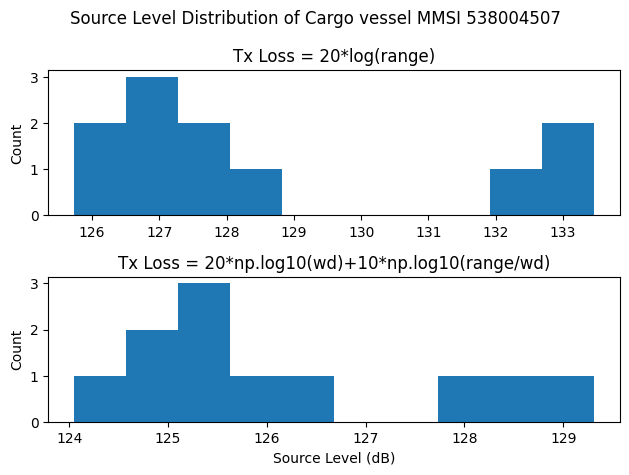

In [103]:
R, Rx_level = Rx_level_from_df(df, 'Central_Caldera')
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.suptitle('Source Level Distribution of '+key+' vessel MMSI 538004507')
loss = np.abs(Tx_loss1(np.asarray(R)))
ax1.hist(np.ma.masked_invalid(Rx_level+loss)) # hide inf (0 divide error) since it messes w/ plotting
ax1.set_ylabel('Count')
ax1.title.set_text('Tx Loss = 20*log(range)')
loss = np.abs(Tx_loss2(np.asarray(R), 'CC'))
ax2.hist(np.ma.masked_invalid(Rx_level+loss))
ax2.set_xlabel('Source Level (dB)')
ax2.set_ylabel('Count')
ax2.title.set_text('Tx Loss = 20*np.log10(wd)+10*np.log10(range/wd)')
fig.tight_layout() 

Text(0, 0.5, 'Mean speed (knots x 10)')

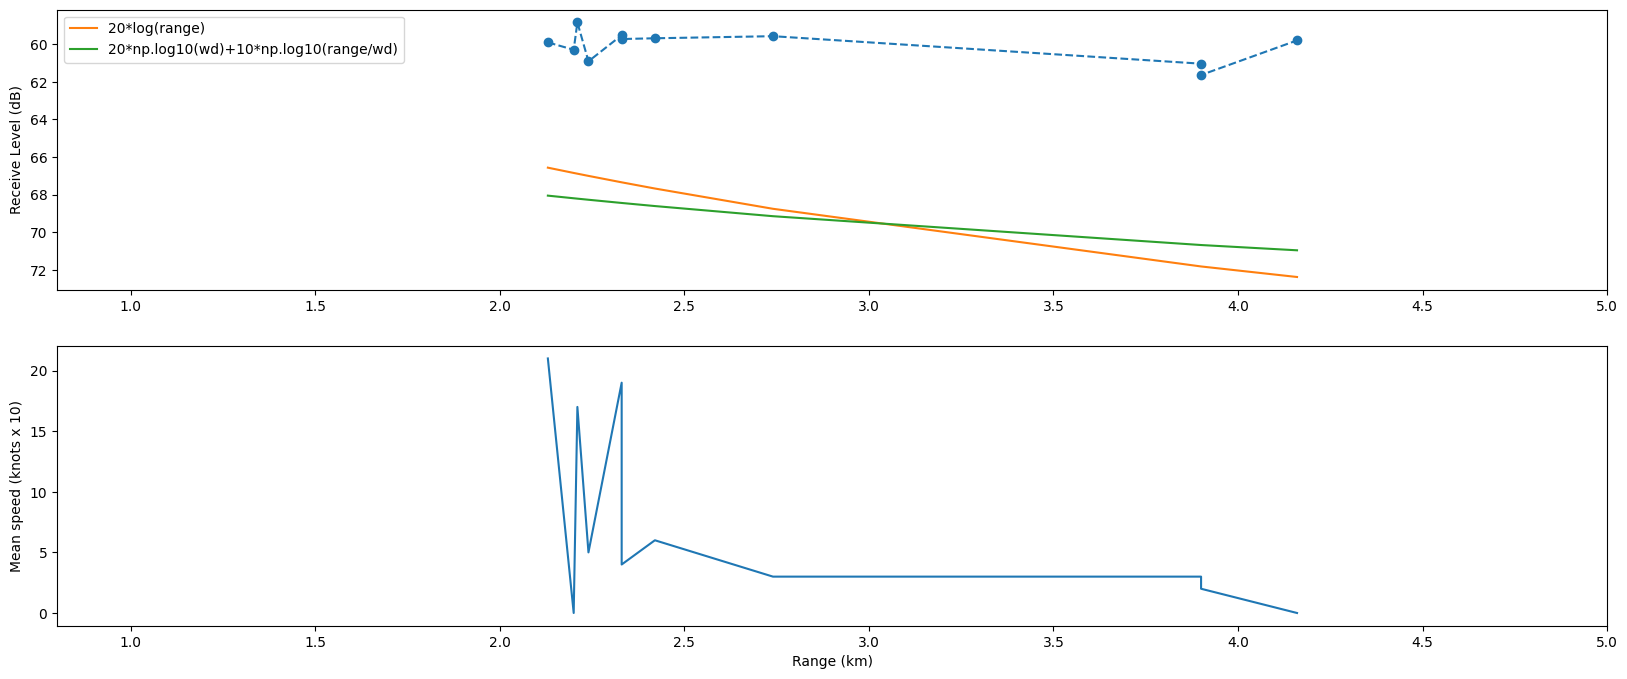

In [104]:
fig, ax = plt.subplots(2, 1, figsize=(20,8))

ax[0].plot(R, Rx_level, 'o--')
ax[0].plot(R, Tx_loss1(np.asarray(R)), label='20*log(range)')
ax[0].plot(R, Tx_loss2(np.asarray(R), 'AB'), label='20*np.log10(wd)+10*np.log10(range/wd)')
#ax[0].set_xlabel('Range (km)')
ax[0].set_ylabel("Receive Level (dB)")
ax[0].legend()
#plt.ylim(47,70)
ax[0].invert_yaxis()#.gca().invert_yaxis()
ax[0].set_xlim(.8,5)

#ax[1,0]
#ax[1].figure(figsize=(20,6))
ax[1].plot(df['mean_distance(in kms)'].sort_values(ascending=True), df["mean_speed(KNOTSx10)"])
ax[1].set_xlim(.8,5)
ax[1].set_xlabel('Range (km)')
ax[1].set_ylabel("Mean speed (knots x 10)")

### Investigation into dB differences
Assigned 5/2/2023. Look into differences in speed, distance, and time of year to identify shifts in dB. 

In laymans terms, figure out what is causing there to be a prominently different percentile curve in the SPDF. 

For MMSI=366345000, there's a ~10 dB from the others. Work on filtering df based on certain criteria (distance/speed threshold) and see if it eliminatess differences in dB percentiles.

By filtering, the high camel hump is around 1.5-1.7 km, which is a common distance so it is unlikely that distance is causing this difference. 3-15 knots still has the hump while higher or lower speeds do not. Results of filtering time show that the hump is present in the timeframe with the most recordings. Perhaps it is normal?

#### Axial Base

Text(0, 0.5, 'count')

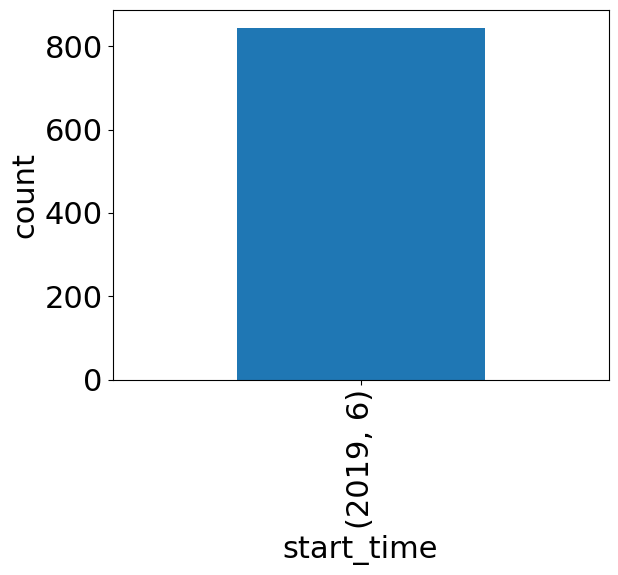

In [125]:
AB_df = pd.read_csv('data/Axial_Base/AB_isolated_ais_10m_5_20.csv', sep=',')
df = AB_df[AB_df['MMSI'] == 367241000]

# these are only dist/speed features atm, need to expand to time as well but this is a start
#feature = 'mean_distance(in kms)'
#feature = 'mean_speed(KNOTSx10)' # has a second group on the high end

# to view dates distribution
feature = 'start_time'
df = df.sort_values(by=[feature])
df[feature] = (pd.to_datetime(df[feature], format='%Y-%m-%d %H:%M:%S'))
df[feature].groupby([df["start_time"].dt.year, df["start_time"].dt.month]).count().plot(kind="bar") # for plotting dates


# speed_diff_max_idx = np.argmax(np.abs(df['min_speed(KNOTSx10)'] - df['max_speed(KNOTSx10)'])) # index of instance w/ greatest diff in min, max speed
# dist_diff_max_idex = np.argmax(np.abs(df['min_distance(in kms)'] - df['max_distance(in kms)']))

plt.hist(df[feature])
plt.xlabel(feature)
plt.ylabel('count')

#### Viewing occurances of MMSIs in given ship type

In [4]:
keys = ['Research', 'Cargo', 'Fishing type']
def MMSI_printer(df, keys):
    """
    Prints top 3 most frequent MMSI for each ship type listed in keys
    """
    for key in keys:
        print(key)
        try:
            occ_df = df[(df['ud_group'] == key)].groupby('MMSI', as_index=False).count().sort_values('ud_group', ascending=False)
            for i in range(3):
                tag = occ_df['MMSI'].iloc[i]
                print(tag)
        except:
            pass
MMSI_printer(AB_df, keys)

Research
366345000
367241000
367800100
Cargo
356190000
352358000
373483000
Fishing type
367466760
303681000
366833610


In [45]:
EC_df = pd.read_csv('data/Eastern_Caldera/EC_isolated_ais_10m_5_20.csv', sep=',')
EC_df.groupby('ud_group').count()
keys = ['Research', 'Cargo', 'Offshore']

MMSI_printer(EC_df, keys)

Research
366345000
367800100
369565000
Cargo
538006456
356190000
372305000
Offshore
338415000


In [117]:
CC_df = pd.read_csv('data/Central_Caldera/CC_isolated_ais_10m_5_20.csv', sep=',')
CC_df.groupby('ud_group').count()
MMSI_printer(CC_df, keys)

Research
366345000
367800100
369565000
Cargo
356190000
372305000
538004507
Offshore
338415000
371186000


# Cepstrum Plotting
Cepstrum is in `log(abs(FFT(signal)))`.
This gives something to use for the y-axis where x-axis would be quefrency.

Higher frequency resolution is needed, so work begins with the audio files, which we will divide into 1-minute intervals to compute the cepstrum of. Then for each vessel type (within each ud_group), we will average the cepstrums.

Can this somehow be plotted like the spdf?

## Initial

In [8]:
rawdf = pd.read_csv('data/Axial_Base/AB_isolated_ais_10m_5_20.csv', sep=',')

options = ['Cargo', 'Tanker', 'Fishing type']
df = rawdf[rawdf['ud_group'].isin(options)]
df = df.reset_index(drop=True)
#df = rawdf[(df['ud_group']=='Cargo') | (df['ud_group']=='Tanker') | (df['ud_group']=='Fishing type')]
# EC is the only one with missing ship type and only 4 of them, just ignore those
# .dropna() followed by .groupby() cleans and groups
grouped_df = df.dropna(subset=['ud_group', 'VESSEL TYPE']).groupby(['ud_group', 'VESSEL TYPE'])
#grouped_df.sum().tail(20)
mean_dict = {}  

# Create average data
for group_name, df_group in grouped_df:
    print(group_name)
    dict = {0: [], 1: [], 2: [], 3: [], 4: [],5: [],6: [], 7: [], 8: [], 9: []}
    for row_index, row in df_group.iterrows():
        inst_id = df['instance_id'].iloc[row_index]
        #inst_id = df[df['Unnamed: 0'] == row_index]['instance_id'][0]
        # data_path = 'data/' + location + '/'
        data_path = 'data/' + 'Axial_Base' + '/'
        wavfilepath = data_path + 'Audio/' + inst_id + '.wav'
        # try-except deals with missing pickles
        try:
            output = wavfile.read(wavfilepath)
            S = output[1]
            w = int(len(S)/10) 
            time_windows = []
            for i in range(1, 11):
                """if (i == 10):
                    window = S[((i-1)*w):]
                else:
                    window = S[((i-1)*w):(i*w)]"""
                # we lose out on very last value
                window = S[((i-1)*w):(i*w)]
                time_windows.append(window)

            # to see time_windows output
            for idx, wind in enumerate(time_windows):
                #print(f'window {idx}: {wind}')
                #print(f'Window {idx} shape is {wind.shape}')
                # compute cf
                cf = (np.log(np.abs(np.fft.fft(wind))))
                if (len(wind) == 12000):
                    dict[idx].append(cf)
                #print(dict[idx][0])
                #plt.plot(cf)

        except FileNotFoundError:
            pass
    # time windows for this group filled out @ this point
    group_cf_mean = 0
    for i in range(len(dict)):
        group_cf_mean += (dict[i][0])#np.mean(dict[i][0], axis=0) Gets first entry window
    group_cf_mean /= len(dict)
    mean_dict.update({str(group_name): group_cf_mean})


('Cargo', 'Bulk Carrier')
('Cargo', 'Cargo')
('Cargo', 'General Cargo')
('Cargo', 'Vehicles Carrier')
('Cargo', 'Wood Chips Carrier')
('Fishing type', 'Fishing Vessel')
('Fishing type', 'Towing Vessel')
('Fishing type', 'Tug')
('Tanker', 'Crude Oil Tanker')
('Tanker', 'LPG Tanker')
('Tanker', 'Oil Products Tanker')
('Tanker', 'Oil/Chemical Tanker')


In [9]:
for k, v in mean_dict.items():
    plt.subplots(figsize=(12, 10))
    print(f'key: {k}, values: {v.shape}')
    plt.plot(mean_dict[k])
    plt.xlabel('frequency')
    #plt.xscale('log')
    title = re.sub('[^A-Za-z0-9 ]+', '', k)
    plt.title(title + ' Cepstrum Plot')
    plt.savefig('data/Axial_Base/Cepstrum/'+ title + '.jpg', format='jpg')
    plt.close()

key: ('Cargo', 'Bulk Carrier'), values: (12000,)
key: ('Cargo', 'Cargo'), values: (12000,)
key: ('Cargo', 'General Cargo'), values: (12000,)
key: ('Cargo', 'Vehicles Carrier'), values: (12000,)
key: ('Cargo', 'Wood Chips Carrier'), values: (12000,)
key: ('Fishing type', 'Fishing Vessel'), values: (12000,)
key: ('Fishing type', 'Towing Vessel'), values: (12000,)
key: ('Fishing type', 'Tug'), values: (12000,)
key: ('Tanker', 'Crude Oil Tanker'), values: (12000,)
key: ('Tanker', 'LPG Tanker'), values: (12000,)
key: ('Tanker', 'Oil Products Tanker'), values: (12000,)
key: ('Tanker', 'Oil/Chemical Tanker'), values: (12000,)


In [11]:
def cepstrum_vesselType_instance(location=None, csv_name=None, vessel_type=None, instance=0, print_options=False):
    rawdf = pd.read_csv('data/'+location+'/'+csv_name, sep=',')

    if (print_options):
        options = ['Cargo', 'Tanker', 'Fishing type']
        df = rawdf[rawdf['ud_group'].isin(options)]
        df = df.reset_index(drop=True)
        #df = rawdf[(df['ud_group']=='Cargo') | (df['ud_group']=='Tanker') | (df['ud_group']=='Fishing type')]
        # EC is the only one with missing ship type and only 4 of them, just ignore those
        # .dropna() followed by .groupby() cleans and groups
        grouped_df = df.dropna(subset=['ud_group', 'VESSEL TYPE']).groupby(['ud_group', 'VESSEL TYPE'])
        #grouped_df.sum().tail(20)
        mean_dict = {}  

        # Create average data
        for group_name, df_group in grouped_df:
            print(group_name)

    options = [vessel_type]
    df = rawdf[rawdf['VESSEL TYPE'].isin(options)]
    df = df.reset_index(drop=True)
    #df = rawdf[(df['ud_group']=='Cargo') | (df['ud_group']=='Tanker') | (df['ud_group']=='Fishing type')]
    # EC is the only one with missing ship type and only 4 of them, just ignore those
    # .dropna() followed by .groupby() cleans and groups
    grouped_df = df.dropna(subset=['ud_group', 'VESSEL TYPE']).groupby(['ud_group', 'VESSEL TYPE'])
    #grouped_df.sum().tail(20)
    mean_dict = {}  
    dict = {0: [], 1: [], 2: [], 3: [], 4: [],5: [],6: [], 7: [], 8: [], 9: []}
    inst_id = df['instance_id'].iloc[instance]
    group = df['ud_group'].iloc[instance]
    #inst_id = df[df['Unnamed: 0'] == row_index]['instance_id'][0]
    # data_path = 'data/' + location + '/'
    data_path = 'data/' + 'Axial_Base' + '/'
    wavfilepath = data_path + 'Audio/' + inst_id + '.wav'
    # try-except deals with missing pickles
    try:
        output = wavfile.read(wavfilepath)
        S = output[1]
        w = int(len(S)/10) 
        time_windows = []
        for i in range(1, 11):
            """if (i == 10):
                window = S[((i-1)*w):]
            else:
                window = S[((i-1)*w):(i*w)]"""
            # we lose out on very last value
            window = S[((i-1)*w):(i*w)]
            time_windows.append(window)

        # to see time_windows output
        for idx, wind in enumerate(time_windows):
            #print(f'window {idx}: {wind}')
            #print(f'Window {idx} shape is {wind.shape}')
            # compute cf
            cf = (np.log(np.abs(np.fft.fft(wind))))
            if (len(wind) == 12000):
                dict[idx].append(cf)
            #print(dict[idx][0])
            #plt.plot(cf)

    except FileNotFoundError:
        pass

    group_cf_mean = 0
    for i in range(len(dict)):
        group_cf_mean += (dict[i][0])#np.mean(dict[i][0], axis=0) Gets first entry window
        group_cf_mean /= len(dict)
    #print(group_cf_mean)
    #mean_dict.update({str(group_name): group_cf_mean})
    #return group_cf_mean
    plt.subplots(figsize=(12, 10))
    plt.plot(group_cf_mean)
    plt.xlabel('frequency')
    #plt.xscale('log')
    title = re.sub('[^A-Za-z0-9 ]+', '', vessel_type)
    plt.title(group + '_' + title + ' Cepstrum Plot')
    #plt.savefig('data/Axial_Base/Cepstrum/'+ title + '.jpg', format='jpg')
    #plt.close()


('Cargo', 'Bulk Carrier')
('Cargo', 'Cargo')
('Cargo', 'General Cargo')
('Cargo', 'Vehicles Carrier')
('Cargo', 'Wood Chips Carrier')
('Fishing type', 'Fishing Vessel')
('Fishing type', 'Towing Vessel')
('Fishing type', 'Tug')
('Tanker', 'Crude Oil Tanker')
('Tanker', 'LPG Tanker')
('Tanker', 'Oil Products Tanker')
('Tanker', 'Oil/Chemical Tanker')


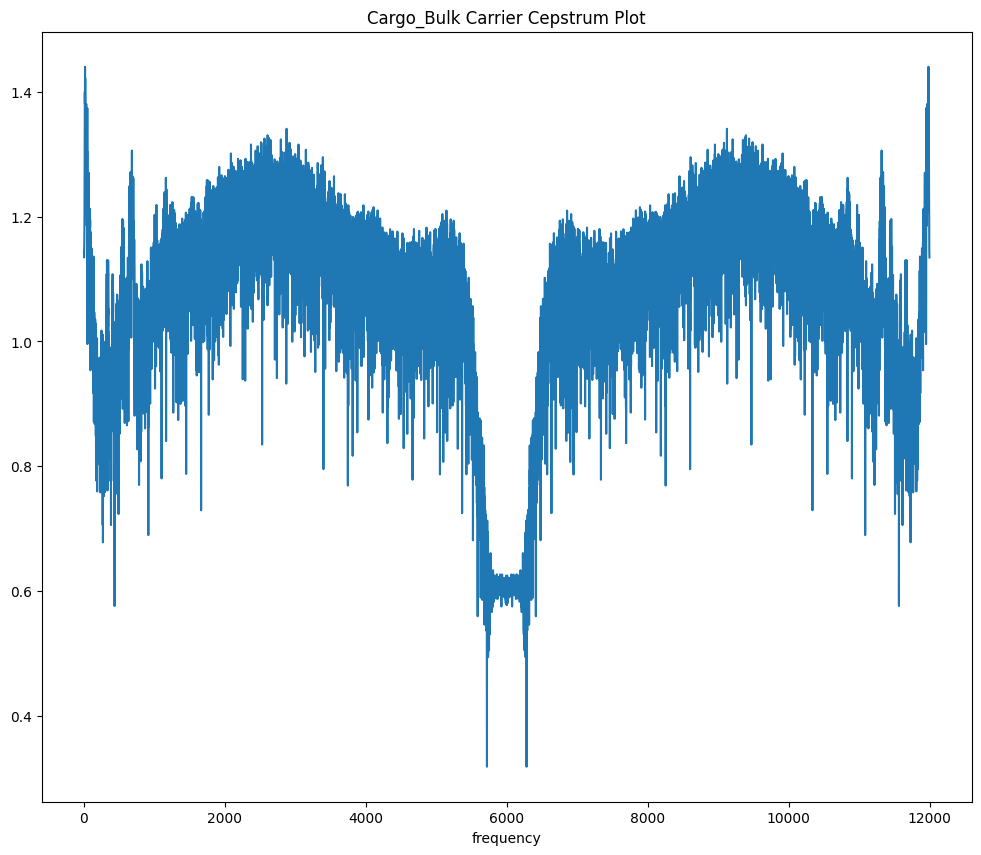

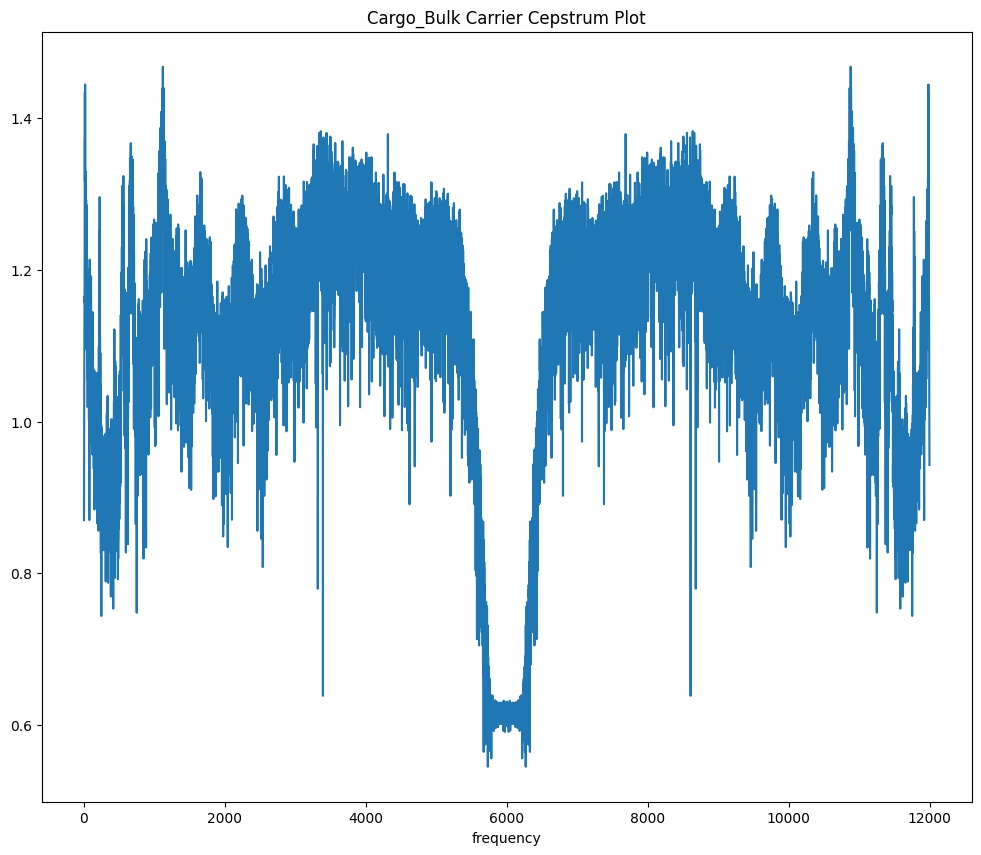

In [19]:
asdf = cepstrum_vesselType_instance(location='Axial_Base', csv_name='AB_isolated_ais_10m_5_20.csv', vessel_type='Bulk Carrier', instance=50, print_options=True)
asdf = cepstrum_vesselType_instance(location='Axial_Base', csv_name='AB_isolated_ais_10m_5_20.csv', vessel_type='Bulk Carrier', instance=0)

## SPDF Cepstrum Plotting

present issues
- [SOLVED] Pxx not scaled correctly. Fix by packing time signal into hdata obj and use `.compute_psd_welch()`
- No way to log/abs the fft within the welch process. Perhaps can do it after(https://en.wikipedia.org/wiki/Cepstrum#Types)? 
but values don't seem like they'd be affected... What if we shove the inverted cepstrum that we make from the actual data into the welch creator? It might calculate the FFT of those which essentially gives back the cepstrum we calculated in the first place

f_og: [  0.        0.78125   1.5625    2.34375   3.125     3.90625   4.6875
   5.46875   6.25      7.03125   7.8125    8.59375   9.375    10.15625
  10.9375   11.71875  12.5      13.28125  14.0625   14.84375  15.625
  16.40625  17.1875   17.96875  18.75     19.53125  20.3125   21.09375
  21.875    22.65625  23.4375   24.21875  25.       25.78125  26.5625
  27.34375  28.125    28.90625  29.6875   30.46875  31.25     32.03125
  32.8125   33.59375  34.375    35.15625  35.9375   36.71875  37.5
  38.28125  39.0625   39.84375  40.625    41.40625  42.1875   42.96875
  43.75     44.53125  45.3125   46.09375  46.875    47.65625  48.4375
  49.21875  50.       50.78125  51.5625   52.34375  53.125    53.90625
  54.6875   55.46875  56.25     57.03125  57.8125   58.59375  59.375
  60.15625  60.9375   61.71875  62.5      63.28125  64.0625   64.84375
  65.625    66.40625  67.1875   67.96875  68.75     69.53125  70.3125
  71.09375  71.875    72.65625  73.4375   74.21875  75.       75.78125
  76.5625   

NameError: name 'sense_corr' is not defined

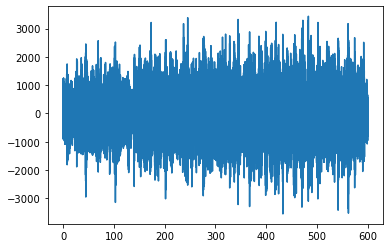

In [3]:
# just look at the psd/audio for now

# this is for figuring out the behavior of a true PSD before moving onto cepstrum
df = pd.read_csv('data/Axial_Base/AB_isolated_ais_10m_5_20.csv', sep=',')
fs = 200 #sample rate
inst_id = df['instance_id'].iloc[0]
data_path = 'data/' + 'Axial_Base' + '/'
wavfilepath = data_path + 'Audio/' + inst_id + '.wav'
try:
    output = wavfile.read(wavfilepath)
    S = output[1]
except FileNotFoundError:
    pass
sec = np.arange(0, len(S)/fs, 1/fs) # t in seconds
L = 256
nfft = L
avg_method="median"
overlap = 0.3
f_og, Pxx_og = welch(S, fs=fs, nfft=nfft, nperseg=L, noverlap=int(L * overlap), average=avg_method)
print(f'f_og: {f_og}')
print(f'Pxx_og: {Pxx_og}')
plt.plot(sec, S)
len(10 * np.log10(Pxx_og * np.power(10, sense_corr / 10)))

### adapted spdf plotter

In [86]:
def get_spdf(spec, fs_hz=200, fmax=None, spl_bins=np.linspace(0, 120, 481),
             percentiles=[1, 5, 10, 50, 90, 95, 99]):
    if fmax is None:
        fmax = 100 #spec.frequency[-1]

    n_freq_bin = int(len(spec['frequencies'][0]) * fmax/(fs_hz/2)) + 1

    spdf_dct = {'freq': np.array(np.linspace(0, fmax, n_freq_bin)),
                'spl': spl_bins[:-1],
                'pdf': np.empty((n_freq_bin, 480))
                #'number_psd': len(spec.time) this isn't used
                }

    for p in percentiles:
        spdf_dct[str(p)] = np.empty(n_freq_bin)

    for idx, freq_bin in enumerate(np.asarray(spec['values']).T[:n_freq_bin - 1]):
        hist, _ = np.histogram(freq_bin, bins=spl_bins, density=True)
        spdf_dct['pdf'][idx] = hist
        spdf_dct['50'][idx] = np.median(freq_bin)
        for p in percentiles:
            spdf_dct[str(p)][idx] = np.nanquantile(freq_bin, p/100)

    return spdf_dct
def plot_ceps_spdf(spdf, vmin=0.003, vmax=0.2, vdelta=0.0025, save=False, filename=None, log=True, title='Spectral PDF', shipType=None, location=None):
    cbarticks = np.arange(vmin, vmax+vdelta, vdelta)
    fig, ax = plt.subplots(figsize=(9, 5))
    im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),
                     cbarticks, norm=colors.Normalize(vmin=vmin, vmax=vmax),
                     cmap='jet', extend='max', alpha=0.50, linewidth=0)

    # plot some percentiles:
    plt.plot(spdf['freq'], spdf['1'], color='black')
    plt.plot(spdf['freq'], spdf['5'], color='black')
    plt.plot(spdf['freq'], spdf['10'], color='black')
    plt.plot(spdf['freq'], spdf['50'], color='black')
    plt.plot(spdf['freq'], spdf['90'], color='black')
    plt.plot(spdf['freq'], spdf['95'], color='black')
    plt.plot(spdf['freq'], spdf['99'], color='black')

    plt.ylabel(r'spectral level (dB rel $1 \mathrm{\frac{μ Pa^2}{Hz}}$)')
    plt.xlabel('frequency (Hz)')
    plt.ylim([0, 100])
    plt.xlim([0, 90])
    if log:
        plt.xscale('log')

    plt.colorbar(im, ax=ax, ticks=[vmin, vmin + (vmax-vmin)/4, vmin + (vmax-vmin)/2,
                 vmin + 3*(vmax-vmin)/4,  vmax],  pad=0.03, label='probability', format='%.3f')
    plt.tick_params(axis='y')
    plt.grid(True)
    plt.title(title)
    handles, labels = plt.gca().get_legend_handles_labels()
    line = Line2D(
        [0], [0], label='percentiles: 1, 5, 10, 50, 90, 95, 99', color='k')
    handles.extend([line])
    plt.legend(handles=handles, loc='upper right')
    plt.tight_layout()
    plt.xlim((200/512, 100))
    filepath = 'data/'+location+'/'+'Cepstrum/SPDF/'
    cleaned_type = ('[^A-Za-z0-9 ]+', '', (shipType))
    plt.savefig(filepath+(title)+'.jpg', format='jpg')
    plt.close() # suppress plotting

### more function

In [3]:
def cepstrum_maker(S):
    w = int(len(S)/10) 
    time_windows = []
    for i in range(1, 11):
        """if (i == 10):
            window = S[((i-1)*w):]
        else:
            window = S[((i-1)*w):(i*w)]"""
        # we lose out on very last value
        window = S[((i-1)*w):(i*w)]
        time_windows.append(window)

    # to see time_windows output
    for idx, wind in enumerate(time_windows):
        #print(f'window {idx}: {wind}')
        #print(f'Window {idx} shape is {wind.shape}')
        # compute cf
        cf = (np.log(np.abs(np.fft.fft(wind))))
        #if (len(wind) == 12000):
        #    dict[idx].append(cf)
    return np.mean(time_windows, axis=0)
    


def get_cepsPSD_dict(meta_data_CSV_path, location, print_options=False):
    """
    From given csv metadata path and location string, give a dictionary of PSD values using the cepstrum
    """
    rawdf = pd.read_csv('data/'+location+'/'+meta_data_CSV_path, sep=',')
    if (print_options):
        options = ['Cargo', 'Tanker', 'Fishing type']
        df = rawdf[rawdf['ud_group'].isin(options)]
        df = df.reset_index(drop=True)
        #df = rawdf[(df['ud_group']=='Cargo') | (df['ud_group']=='Tanker') | (df['ud_group']=='Fishing type')]
        # EC is the only one with missing ship type and only 4 of them, just ignore those
        # .dropna() followed by .groupby() cleans and groups
        grouped_df = df.dropna(subset=['ud_group', 'VESSEL TYPE']).groupby(['ud_group', 'VESSEL TYPE'])
        #grouped_df.sum().tail(20)
        mean_dict = {}  

        # Create average data
        for group_name, df_group in grouped_df:
            print(group_name)

    options = ['Cargo', 'Tanker', 'Fishing type']
    df = rawdf[rawdf['VESSEL TYPE'].isin(options)]
    df = rawdf.reset_index(drop=True)
    grouped_df = df.dropna(subset=['ud_group', 'VESSEL TYPE']).groupby(['ud_group', 'VESSEL TYPE'])

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    PSDs = {}
    for group_name, df_group in grouped_df:
        PSD_freq = []
        PSD_val = []
        dictPSD = { 'frequencies': PSD_freq, 'values': PSD_val}

        # for-loop to compile list of PSD data objects pulled from column
        for row_index, row in df_group.iterrows():
            inst_id = df['instance_id'].iloc[row_index]
            # get pickle files (DL locally? Call some API?)
            # local storage method
            data_path = 'data/' + location + '/'
            wavfilepath = data_path + 'Audio/' + inst_id + '.wav'
            # try-except deals with missing pickles
            try:
                output = wavfile.read(wavfilepath)
                S = output[1]
                total_cf = np.log(np.abs(np.fft.fft(S)))
                total_quefrec = np.fft.ifft(total_cf)
                cf = cepstrum_maker(S)
                icf = np.fft.ifft(cf)
                #print(cf)
                obj = ooipy.hydrophone.basic.HydrophoneData(data=np.real(icf), header=None, node="Axial_Base")
                obj.stats.sampling_rate = 200
                obj.stats.channel = 'HDH'
                obj.compute_psd_welch(L = 256, overlap=0.3)
                #print(obj.stats)
                psd = obj.psd   
                dictPSD['frequencies'].append(psd.freq)
                dictPSD['values'].append(psd.values)
            except FileNotFoundError:
                pass
        PSDs.update({group_name: dictPSD})
    return PSDs

In [71]:
test = get_cepsPSD_dict('AB_isolated_ais_10m_5_20.csv', location='Axial_Base')

In [87]:
"""for i in test.keys():
    print(i)
    print(test[i]['values'])"""

for key in test:
    print((key))
    spdf = get_spdf(test[key])
    title = re.sub('[^A-Za-z0-9 ]+', '', str(key))
    plot_ceps_spdf(spdf, log=False, title=title + ' Spectral PDF', shipType=str(key), location='Axial_Base')


('Cargo', 'Bulk Carrier')


C:\Users\UserALai\AppData\Local\Temp\ipykernel_5100\3404231315.py:28: UserWarning: The following kwargs were not used by contour: 'linewidth'
  im = ax.contourf(spdf['freq'], spdf['spl'], np.transpose(spdf['pdf']),


('Cargo', 'Cargo')
('Cargo', 'General Cargo')
('Cargo', 'Vehicles Carrier')
('Cargo', 'Wood Chips Carrier')
('Fishing type', 'Fishing Vessel')


C:\Users\UserALai\miniconda3\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


('Fishing type', 'Towing Vessel')
('Fishing type', 'Tug')
('Passenger', 'Passenger Ship')
('Recreational', 'Passenger')
('Recreational', 'Yacht')
('Research', 'Research/Survey Vessel')
('Research', 'Special Vessel')
('Tanker', 'Crude Oil Tanker')
('Tanker', 'LPG Tanker')
('Tanker', 'Oil Products Tanker')
('Tanker', 'Oil/Chemical Tanker')


## Cepstrum Spectrograms

In [3]:
def cep_spectrogram(meta_data_CSV_path, location, print_options=False):
    """
    From given csv metadata path and location string, generate spectrogram plot using cepstrum
    """
    rawdf = pd.read_csv('data/'+location+'/'+meta_data_CSV_path, sep=',')
    if (print_options):
        options = ['Cargo', 'Tanker', 'Fishing type']
        df = rawdf[rawdf['ud_group'].isin(options)]
        df = df.reset_index(drop=True)
        grouped_df = df.dropna(subset=['ud_group', 'VESSEL TYPE']).groupby(['ud_group', 'VESSEL TYPE'])
        mean_dict = {}  

        # Create average data
        for group_name, df_group in grouped_df:
            print(group_name)

    options = ['Cargo', 'Tanker', 'Fishing type']
    df = rawdf[rawdf['VESSEL TYPE'].isin(options)]
    df = rawdf.reset_index(drop=True)
    grouped_df = df.dropna(subset=['ud_group', 'VESSEL TYPE']).groupby(['ud_group', 'VESSEL TYPE'])

    # https://stackoverflow.com/questions/27405483/how-to-loop-over-grouped-pandas-dataframe
    for group_name, df_group in grouped_df:
        for row_index, row in df_group.iterrows():
            inst_id = df['instance_id'].iloc[row_index]
            # get pickle files (DL locally? Call some API?)
            # local storage method
            data_path = 'data/' + location + '/'
            wavfilepath = data_path + 'Audio/' + inst_id + '.wav'
            # try-except deals with missing pickles
            try:
                output = wavfile.read(wavfilepath)
                S = output[1]
                cf = cepstrum_maker(S)
                icf = np.fft.ifft(cf)
                #print(cf)
                obj = ooipy.hydrophone.basic.HydrophoneData(data=np.real(icf), header=None, node="Axial_Base")
                obj.stats.sampling_rate = 200
                obj.stats.channel = 'HDH'
                spectrogram = obj.compute_spectrogram(L = 256,avg_time=10, overlap=0.9)
                fmin=0
                fmax=100
                path = 'data/'+location+'/Cepstrum/Spectrograms/'
                ooiplt.plot_spectrogram(spectrogram,plot=False,save=True,fmin=fmin,fmax=fmax,vmax=110,filename=path+inst_id+'.png')
                print(inst_id)
                #print(obj.stats)
            except FileNotFoundError:
                pass

In [13]:
cep_spectrogram('AB_isolated_ais_10m_5_20.csv', location='Axial_Base')

c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning: The following kwargs were not used by contour: 'plot', 'save', 'fmin', 'fmax', 'filename', 'title', 'xlabel', 'xlabel_rot', 'xlabel_format', 'ylabel', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'
  ax.contourf(


AB_20161125224956_20161125225956
AB_20160401185825_20160401190825
AB_20160401190825_20160401191825
AB_20200924194145_20200924195145
AB_20180523063517_20180523064517
AB_20161003212449_20161003213449
AB_20160820141731_20160820142731
AB_20160820142731_20160820143731
AB_20160820143731_20160820144731
AB_20160820144731_20160820145731
AB_20160820145731_20160820150731
AB_20160820150731_20160820151731
AB_20160820151731_20160820152731
AB_20160820152731_20160820153731
AB_20160820153731_20160820154731
AB_20170817032252_20170817033252
AB_20170817033252_20170817034252
AB_20170817034252_20170817035252
AB_20170817035252_20170817040252
AB_20170817040252_20170817041252
AB_20170817041252_20170817042252
AB_20170817042252_20170817043252
AB_20170817043252_20170817044252
AB_20170817044252_20170817045252
AB_20170817045252_20170817050252
AB_20170817050252_20170817051252
AB_20170817051252_20170817052252
AB_20170817052252_20170817053252
AB_20170817053252_20170817054252
AB_20170817054252_20170817055252
AB_2017081

TypeError: Input z must be at least a (2, 2) shaped array, but has shape (129, 1)

In [4]:
rawdf = pd.read_csv('data/'+'Axial_Base'+'/'+'AB_isolated_ais_10m_5_20.csv', sep=',')
options = ['Cargo', 'Tanker', 'Fishing type']
df = rawdf[rawdf['VESSEL TYPE'].isin(options)]
df = rawdf.reset_index(drop=True)
grouped_df = df.dropna(subset=['ud_group', 'VESSEL TYPE']).groupby(['ud_group', 'VESSEL TYPE'])

inst_id = df['instance_id'].iloc[0]

wavfilepath = 'data/Axial_Base/' + 'Audio/' + inst_id + '.wav'
try:
    output = wavfile.read(wavfilepath)
    S = output[1]
    cf = cepstrum_maker(S)
    icf = np.fft.ifft(cf)
    #print(cf)
    obj = ooipy.hydrophone.basic.HydrophoneData(data=np.real(icf), header=None, node="Axial_Base")
    obj.stats.sampling_rate = 200
    obj.stats.channel = 'HDH'
    spectrogram = obj.compute_spectrogram(L = 256,avg_time=10, overlap=0.9)
    fmin=0
    fmax=1200
except FileNotFoundError:
    pass

In [5]:
len(S)

120001

In [8]:
len(obj)    
w = int(len(S)/10) 
time_windows = []
for i in range(1, 11):
    """if (i == 10):
        window = S[((i-1)*w):]
    else:
        window = S[((i-1)*w):(i*w)]"""
    # we lose out on very last value
    window = S[((i-1)*w):(i*w)]
    time_windows.append(window)

# to see time_windows output
for idx, wind in enumerate(time_windows):
    #print(f'window {idx}: {wind}')
    #print(f'Window {idx} shape is {wind.shape}')
    # compute cf
    cf = (np.log(np.abs(np.fft.fft(wind))))
    #if (len(wind) == 12000):
    #    dict[idx].append(cf)


In [6]:
plt.plot(S)
plt.show()

In [20]:
for i in (time_windows[5]):
    print(i)


-595.56604
147.43396
536.43396
-959.56604
-1167.566
180.43396
1213.434
144.43396
-823.56604
240.43396
946.43396
244.43396
-226.56604
305.43396
-216.56604
-581.56604
-299.56604
-114.56604
-210.56604
-152.56604
629.43396
-325.56604
-729.56604
960.43396
734.43396
-637.56604
-541.56604
172.43396
939.43396
22.433964
-1310.566
744.43396
1567.434
-681.56604
-1071.566
424.43396
742.43396
-787.56604
-753.56604
426.43396
24.433964
-176.56604
895.43396
100.43396
-591.56604
932.43396
455.43396
-0.56603694
-116.56604
37.433964
255.43396
-552.56604
65.43396
897.43396
200.43396
-1489.566
7.433963
1364.434
-33.566036
-754.56604
-321.56604
480.43396
-269.56604
-100.56604
72.43396
339.43396
323.43396
-454.56604
731.43396
232.43396
-716.56604
-470.56604
198.43396
198.43396
-625.56604
81.43396
463.43396
362.43396
81.43396
243.43396
620.43396
-108.56604
-271.56604
198.43396
-115.56604
-603.56604
-126.56604
-196.56604
-531.56604
507.43396
777.43396
-290.56604
146.43396
559.43396
-758.56604
-1102.566
112.433

In [24]:
spec = obj.compute_spectrogram(avg_time=1, overlap=0)
spec.values.shape
ooipy.plot(spec, fmin=0, fmax=1200)
plt.show()

KeyboardInterrupt: 

In [28]:
obj.data.shape

(12000,)

In [7]:
sp = obj.compute_spectrogram(L = 256,avg_time=10, overlap=0.9)
ooipy.plot(sp, fmax=100, xlabel_rot=30)
sp.values.shape
obj2 = ooipy.hydrophone.basic.HydrophoneData(data=S, header=None, node="Axial_Base")
obj2.stats.sampling_rate = 200
obj2.stats.channel = 'HDH'
sp2 = obj2.compute_spectrogram(L = 256,avg_time=10, overlap=0.9)
ooipy.plot(sp2, fmax=100, xlabel_rot=30)

c:\Users\UserALai\miniconda3\lib\site-packages\ooipy\tools\ooiplotlib.py:218: UserWarning: The following kwargs were not used by contour: 'fmax', 'xlabel_rot', 'plot', 'save', 'filename', 'title', 'xlabel', 'xlabel_format', 'ylabel', 'fmin', 'vdelta', 'vdelta_cbar', 'figsize', 'res_reduction_time', 'res_reduction_freq', 'dpi', 'fontsize', 'extend_type', 'logy'
  ax.contourf(
